In [1]:
%run setup.ipynb
%run peak-utils.ipynb

In [90]:
def peak_scan(pop, chromosome, 
              filter_kws=dict(size=20, t=2), 
              gflanks=(4, 8), 
              scan_interval=1,
              min_aic=500,
              min_baseline=0,
              max_baseline_percentile=95,
              min_amplitude=0.03,
              init_amplitude=0.5,
              max_amplitude=1.5,
              min_decay=0.1,
              init_decay=0.5,
              max_abs_skew=0.5,
              diagnostics=False,
              scan_start=None,
              scan_stop=None,
              ):

    # load gwss data
    pwindows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # filter 
    signal_filtered = hampel_filter(signal, **filter_kws)

    # diagnostics
    if diagnostics:
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), facecolor='w')
        axs[0].plot(gpos, signal, marker='o', linestyle=' ', markersize=1)
        axs[0].set_title('Original signal')
        axs[1].plot(gpos, signal_filtered, marker='o', linestyle=' ', markersize=1)
        axs[1].set_title('Filtered signal')
        fig.tight_layout()
        plt.show()
        plt.close()

    # set parameters
    init_baseline = np.median(signal_filtered)
    max_baseline = np.percentile(signal_filtered, max_baseline_percentile)
    min_skew, init_skew, max_skew = -max_abs_skew, 0, max_abs_skew
    
    # setup output
    records = []
    
    # iterate through genome
    if not scan_start:
        scan_start = 2
    if not scan_stop:
        scan_stop = gmap[chromosome][-1] - 2
    for gcenter in np.arange(scan_start, scan_stop, scan_interval):
    
        for gflank in gflanks:

            # locate region to fit
            loc_region = slice(bisect_left(gpos, gcenter - gflank), 
                               bisect_right(gpos, gcenter + gflank))

            # setup data to fit
            x = gpos[loc_region]
            y = signal_filtered[loc_region]

            # fit peak model
            peak_model = lmfit.Model(skewed_exponential_peak)
            peak_params = lmfit.Parameters()
            peak_params['center'] = lmfit.Parameter('center', vary=True, 
                                                    value=gcenter, 
                                                    min=gcenter - gflank, 
                                                    max=gcenter + gflank)
            peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, 
                                                       value=init_amplitude, 
                                                       min=min_amplitude, 
                                                       max=max_amplitude)
            peak_params['decay'] = lmfit.Parameter('decay', 
                                                   vary=True, 
                                                   value=init_decay, 
                                                   min=min_decay, 
                                                   max=gflank/3)
            peak_params['skew'] = lmfit.Parameter('skew', 
                                                  vary=True, 
                                                  value=init_skew, 
                                                  min=min_skew, 
                                                  max=max_skew)
            peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, 
                                                      value=init_baseline, 
                                                      min=min_baseline, 
                                                      max=max_baseline)
            peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
            peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
            peak_result = peak_model.fit(y, x=x, params=peak_params)

            # fit null model
            null_model = lmfit.models.ConstantModel()
            null_params = lmfit.Parameters()
            null_params['c'] = lmfit.Parameter('c', vary=True, value=init_baseline, min=0, max=1)
            null_result = null_model.fit(y, x=x, params=null_params)

            # compute fit
            peak_delta_i = null_result.aic - peak_result.aic

            # determine if we want to emit a result - we will do this if delta_i is above threshold
            # and also only if the peak center is within the scan interval - if it is beyond, then 
            # we will get a better fit in a different scan interval
            fit_gcenter = peak_result.params['center'].value
            peak_in_scan_interval = ((gcenter - scan_interval) < fit_gcenter < (gcenter + scan_interval))
            
            if peak_delta_i > min_aic and peak_in_scan_interval:
                
                fit_params = peak_result.params
                fit_skew = fit_params['skew'].value
                fit_decay = fit_params['decay'].value
                decay_right = 2**(-fit_skew) * fit_decay
                decay_left = 2**fit_skew * fit_decay
                span1_gstart = fit_gcenter - 1*decay_left
                span1_gstop = fit_gcenter + 1*decay_right
                span2_gstart = fit_gcenter - 2*decay_left
                span2_gstop = fit_gcenter + 2*decay_right
                
                # physical position
                fit_pcenter = bisect_left(gmap[chromosome], fit_gcenter)
                span1_pstart = bisect_left(gmap[chromosome], span1_gstart)
                span1_pstop = bisect_right(gmap[chromosome], span1_gstop)
                span2_pstart = bisect_left(gmap[chromosome], span2_gstart)
                span2_pstop = bisect_right(gmap[chromosome], span2_gstop)
                
                # TODO arm physical position
                
                # locus
                locus = None
                for gene in ir_genes + [tep1]:
                    if gene.chromosome == chromosome:
                        disjoint = (gene.chromosome_end < span1_pstart or gene.chromosome_start > span1_pstop)
                        if not disjoint:
                            locus = gene['Name']
                for k, (c, p) in novel_loci.items():
                    if c == chromosome and span1_pstart < p < span1_pstop:
                        locus = k
                print(fit_pcenter, locus)
                
                # TODO max value, loc max value (g, p)
                
                record = dict(
                    pop=pop,
                    chromosome=chromosome,
                    gcenter=fit_gcenter,
                    pcenter=fit_pcenter,
                    delta_i=peak_delta_i,
                    locus=locus,
                    span1_gstart=span1_gstart,
                    span1_gstop=span1_gstop,
                    span2_gstart=span2_gstart,
                    span2_gstop=span2_gstop,
                    span1_pstart=span1_pstart,
                    span1_pstop=span1_pstop,
                    span2_pstart=span2_pstart,
                    span2_pstop=span2_pstop,
                    amplitude=fit_params['amplitude'].value,
                    decay=fit_decay,
                    skew=fit_skew,
                    decay_left=decay_left,
                    decay_right=decay_right,
                    baseline=fit_params['baseline'].value,
                    aic=peak_result.aic,
                    bic=peak_result.bic,
                    rss=peak_result.chisqr,
                    constant_aic=null_result.aic,
                    params=fit_params,
                    result=peak_result,
                )
                records.append(record)
                
                if diagnostics:
                    fig, ax = plt.subplots(facecolor='w', figsize=(8, 4))
                    peak_result.plot_fit(
                        ax=ax, 
                        xlabel=f'Chromosome {chromosome} position (cM)', 
                        ylabel='$H12$',
                        data_kws=dict(markersize=2), 
                        fit_kws=dict(color='k', linestyle='--')
                    )
                    ax.axvline(gcenter, color='w', lw=2, zorder=0)
                    ax.axvspan(fit_gcenter - decay_left, fit_gcenter + decay_right, zorder=0, color='red', alpha=.2)
                    ax.axvspan(fit_gcenter - 2*decay_left, fit_gcenter + 2*decay_right, zorder=0, color='red', alpha=.2)
                    ax.axvline(fit_gcenter, color='red', lw=2, zorder=0)
                    ax.annotate(
                        f'$AIC={peak_result.aic:.0f}$\n' +
                        f'$BIC={peak_result.bic:.0f}$\n' +
                        f'$\\chi^{2}={peak_result.chisqr:.3f}$\n' +
                        f'$\\Delta_{{i}}={null_result.aic - peak_result.aic:.0f}$',
                        xy=(0, 1), xycoords='axes fraction',
                        xytext=(5, -5), textcoords='offset points',
                        va='top', ha='left', fontsize=8,
                    )
                    ax.set_xlim(gcenter - gflank, gcenter + gflank)
                    fig.tight_layout()
                    plt.show()
                    plt.close()
                    print(peak_result.fit_report())
                    
    return pd.DataFrame.from_records(records)


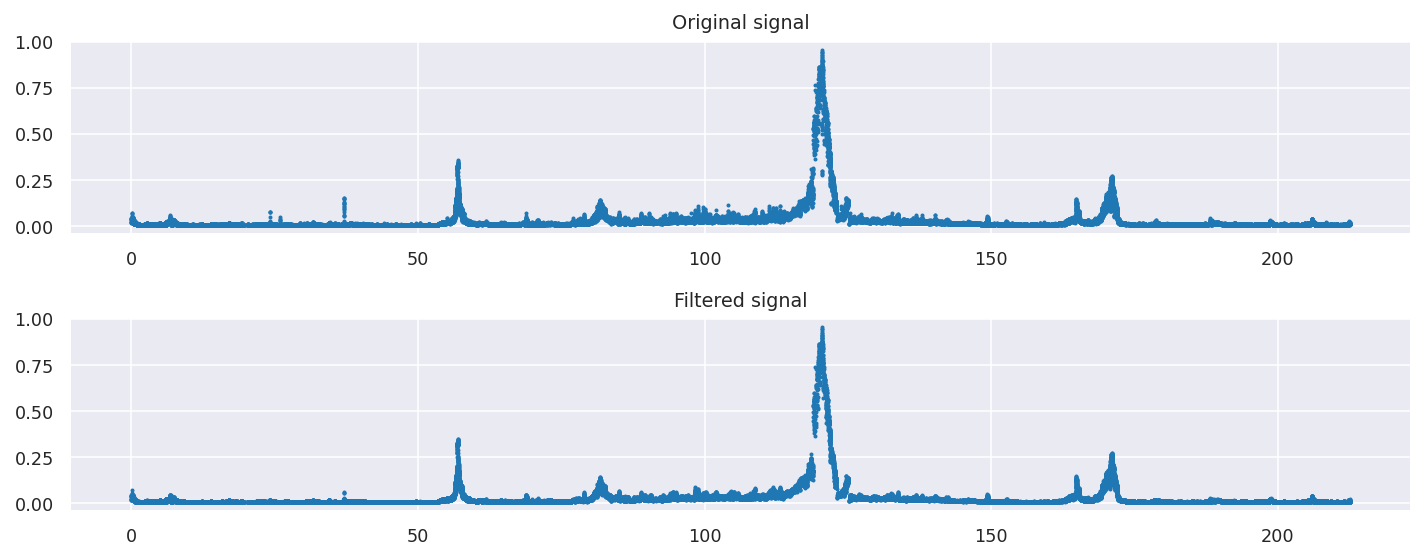

3412422 Ace1


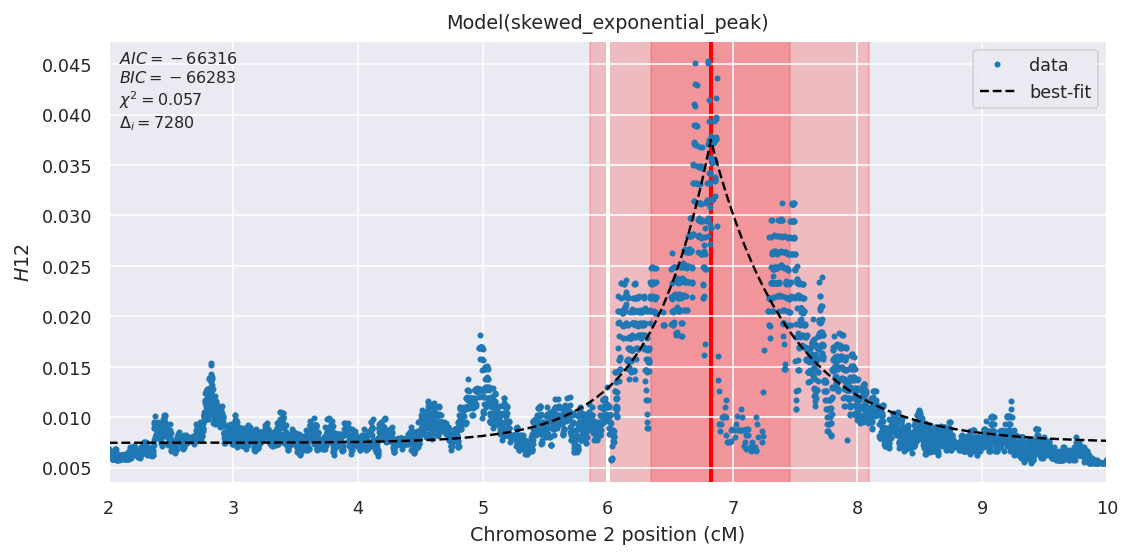

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 443
    # data points      = 5757
    # variables        = 5
    chi-square         = 0.05711099
    reduced chi-square = 9.9289e-06
    Akaike info crit   = -66315.9973
    Bayesian info crit = -66282.7064
[[Variables]]
    center:     6.82484494 +/- 0.00489898 (0.07%) (init = 6)
    amplitude:  0.03000000 +/- 0.00255050 (8.50%) (init = 0.5)
    decay:      0.55225101 +/- 0.00746276 (1.35%) (init = 0.5)
    skew:      -0.19472768 +/- 0.01572589 (8.08%) (init = 0)
    baseline:   0.00748671 +/- 5.9705e-05 (0.80%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.700
    C(decay, baseline)   = -0.592
    C(amplitude, decay)  =  0.557
    C(center, amplitude) = -0.322
    C(amplitude, skew)   = -0.155
3413361 Ace1


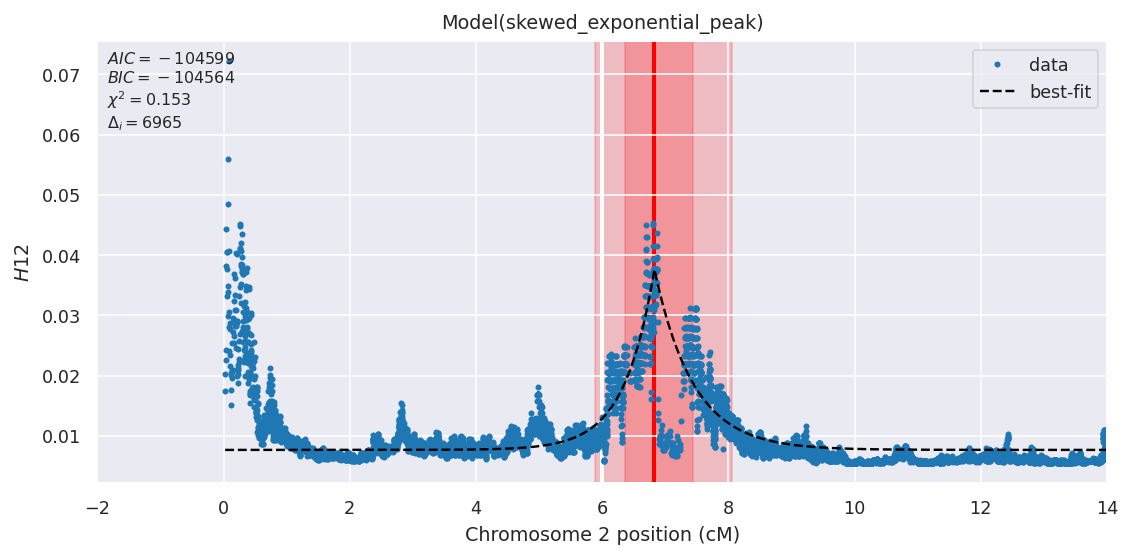

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 438
    # data points      = 9480
    # variables        = 5
    chi-square         = 0.15292676
    reduced chi-square = 1.6140e-05
    Akaike info crit   = -104599.295
    Bayesian info crit = -104563.510
[[Variables]]
    center:     6.82672372 +/- 0.00619766 (0.09%) (init = 6)
    amplitude:  0.03000000 +/- 1.3170e-04 (0.44%) (init = 0.5)
    decay:      0.53871722 +/- 0.00844628 (1.57%) (init = 0.5)
    skew:      -0.19024437 +/- 0.02030123 (10.67%) (init = 0)
    baseline:   0.00765072 +/- 4.9945e-05 (0.65%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.699
    C(amplitude, decay)  =  0.622
    C(decay, baseline)   = -0.441
    C(center, amplitude) = -0.334
    C(amplitude, skew)   = -0.160
3414685 Ace1


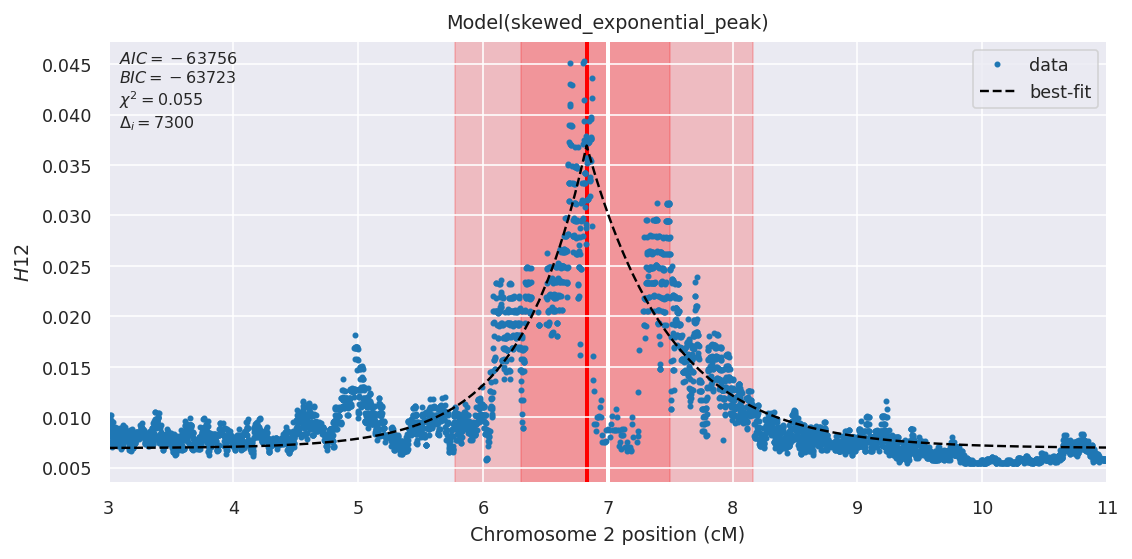

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 167
    # data points      = 5538
    # variables        = 5
    chi-square         = 0.05530147
    reduced chi-square = 9.9948e-06
    Akaike info crit   = -63756.4402
    Bayesian info crit = -63723.3432
[[Variables]]
    center:     6.82937153 +/- 0.00519875 (0.08%) (init = 7)
    amplitude:  0.03000000 +/- 1.5808e-05 (0.05%) (init = 0.5)
    decay:      0.59400189 +/- 0.00824061 (1.39%) (init = 0.5)
    skew:      -0.16883074 +/- 0.01525516 (9.04%) (init = 0)
    baseline:   0.00695558 +/- 6.6200e-05 (0.95%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.710
    C(decay, baseline)   = -0.647
    C(amplitude, decay)  =  0.551
    C(center, amplitude) = -0.348
    C(amplitude, skew)   = -0.185
    C(center, decay)     = -0.102
3413537 Ace1


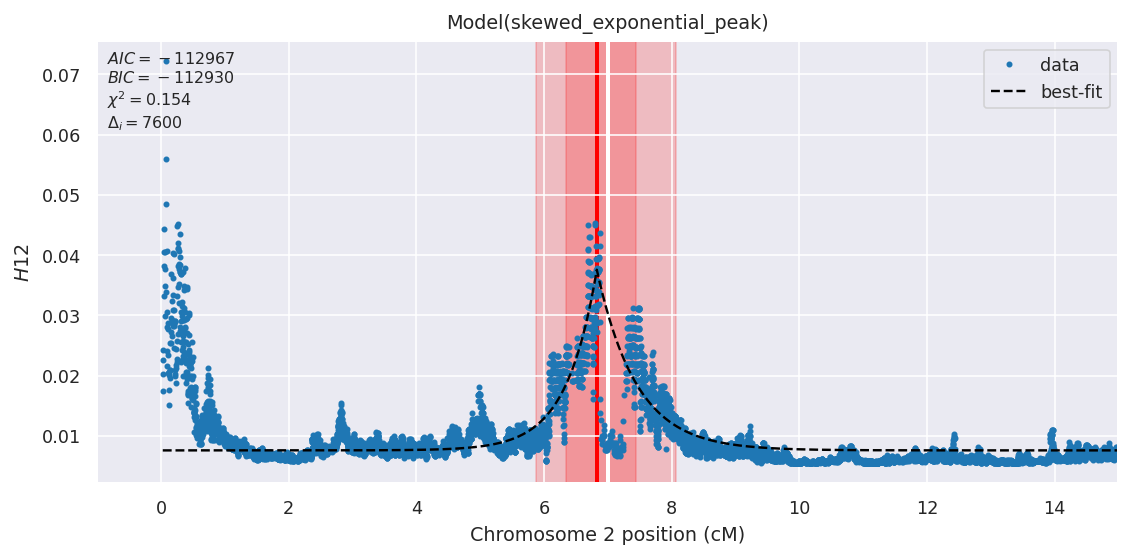

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 131
    # data points      = 10177
    # variables        = 5
    chi-square         = 0.15361953
    reduced chi-square = 1.5102e-05
    Akaike info crit   = -112966.524
    Bayesian info crit = -112930.385
[[Variables]]
    center:     6.82707570 +/- 0.00603529 (0.09%) (init = 7)
    amplitude:  0.03000000 +/- 3.5362e-05 (0.12%) (init = 0.5)
    decay:      0.54475082 +/- 0.00814884 (1.50%) (init = 0.5)
    skew:      -0.18741387 +/- 0.01952437 (10.42%) (init = 0)
    baseline:   0.00757110 +/- 4.6017e-05 (0.61%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.700
    C(amplitude, decay)  = -0.628
    C(decay, baseline)   = -0.426
    C(center, amplitude) =  0.332
    C(amplitude, skew)   =  0.160
3572586 Ace1


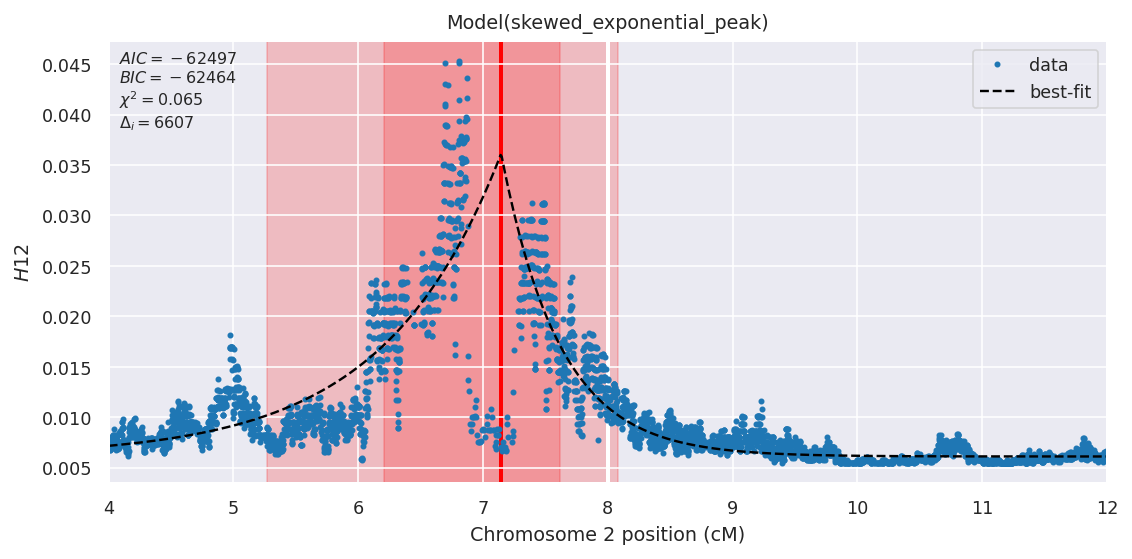

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 271
    # data points      = 5510
    # variables        = 5
    chi-square         = 0.06521871
    reduced chi-square = 1.1847e-05
    Akaike info crit   = -62497.2515
    Bayesian info crit = -62464.1799
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    skew:       at boundary
[[Variables]]
    center:     7.14517315 (init = 8)
    amplitude:  0.03000000 (init = 0.5)
    decay:      0.66459112 (init = 0.5)
    skew:       0.50000000 (init = 0)
    baseline:   0.00612856 (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
3570865 Ace1


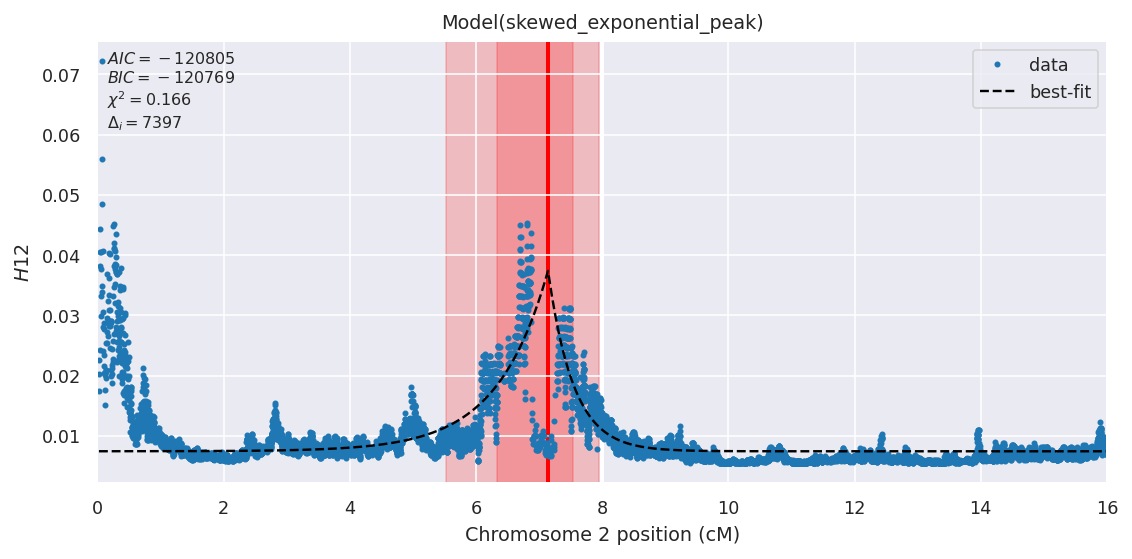

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 239
    # data points      = 10894
    # variables        = 5
    chi-square         = 0.16627269
    reduced chi-square = 1.5270e-05
    Akaike info crit   = -120805.480
    Bayesian info crit = -120769.000
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    skew:       at boundary
[[Variables]]
    center:     7.14173110 (init = 8)
    amplitude:  0.03000000 (init = 0.5)
    decay:      0.56937468 (init = 0.5)
    skew:       0.50000000 (init = 0)
    baseline:   0.00742321 (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
28460966 Cyp6p3


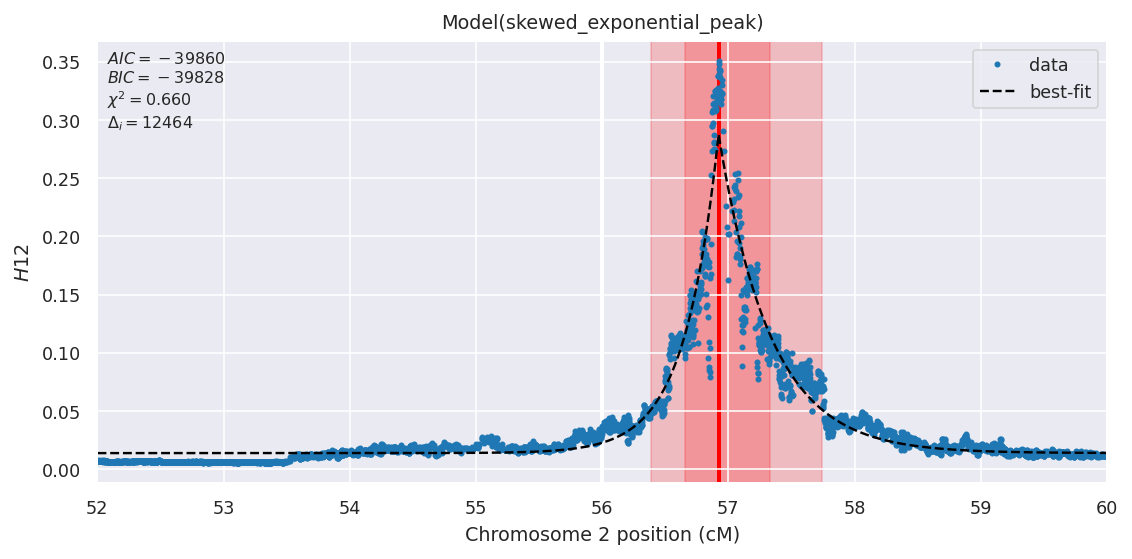

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 4515
    # variables        = 5
    chi-square         = 0.66008670
    reduced chi-square = 1.4636e-04
    Akaike info crit   = -39859.9086
    Bayesian info crit = -39827.8328
[[Variables]]
    center:     56.9219327 +/- 0.00168051 (0.00%) (init = 56)
    amplitude:  0.27379865 +/- 0.00144716 (0.53%) (init = 0.5)
    decay:      0.33261520 +/- 0.00251668 (0.76%) (init = 0.5)
    skew:      -0.30616901 +/- 0.00981862 (3.21%) (init = 0)
    baseline:   0.01391129 +/- 2.2016e-04 (1.58%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.722
    C(amplitude, decay)  = -0.639
    C(decay, baseline)   = -0.437
    C(center, amplitude) =  0.211
    C(decay, skew)       =  0.159
    C(amplitude, skew)   =  0.104
28460960 Cyp6p3


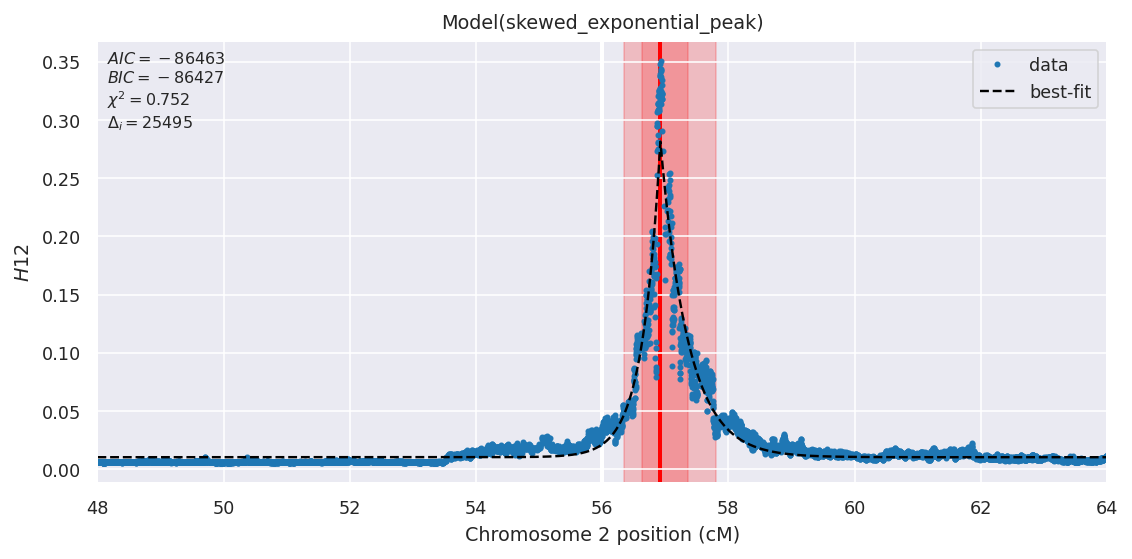

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 162
    # data points      = 9189
    # variables        = 5
    chi-square         = 0.75223727
    reduced chi-square = 8.1907e-05
    Akaike info crit   = -86462.7710
    Bayesian info crit = -86427.1422
[[Variables]]
    center:     56.9219206 +/- 0.00131105 (0.00%) (init = 56)
    amplitude:  0.27107642 +/- 0.00103860 (0.38%) (init = 0.5)
    decay:      0.35581056 +/- 0.00185953 (0.52%) (init = 0.5)
    skew:      -0.30480237 +/- 0.00718453 (2.36%) (init = 0)
    baseline:   0.01038576 +/- 1.0397e-04 (1.00%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.724
    C(amplitude, decay)  = -0.672
    C(decay, baseline)   = -0.304
    C(decay, skew)       =  0.185
    C(center, amplitude) =  0.183
28461062 Cyp6p3


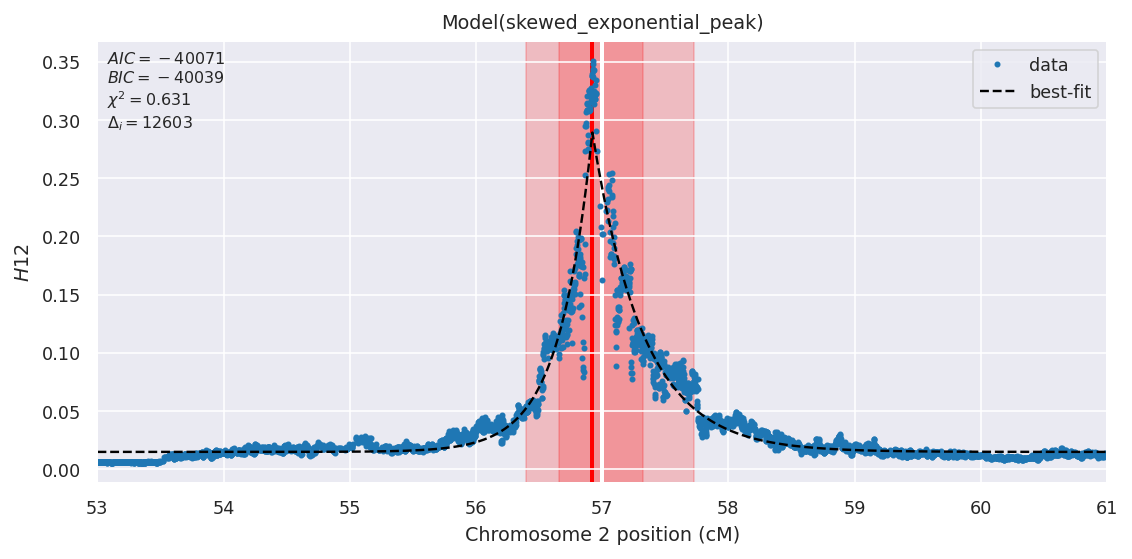

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 4516
    # variables        = 5
    chi-square         = 0.63135107
    reduced chi-square = 1.3996e-04
    Akaike info crit   = -40070.7424
    Bayesian info crit = -40038.6655
[[Variables]]
    center:     56.9221250 +/- 0.00162463 (0.00%) (init = 57)
    amplitude:  0.27455020 +/- 0.00142941 (0.52%) (init = 0.5)
    decay:      0.32633722 +/- 0.00242644 (0.74%) (init = 0.5)
    skew:      -0.30580613 +/- 0.00966524 (3.16%) (init = 0)
    baseline:   0.01493715 +/- 2.1449e-04 (1.44%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.722
    C(amplitude, decay)  = -0.640
    C(decay, baseline)   = -0.434
    C(center, amplitude) =  0.210
    C(decay, skew)       =  0.160
    C(amplitude, skew)   =  0.103
28460960 Cyp6p3


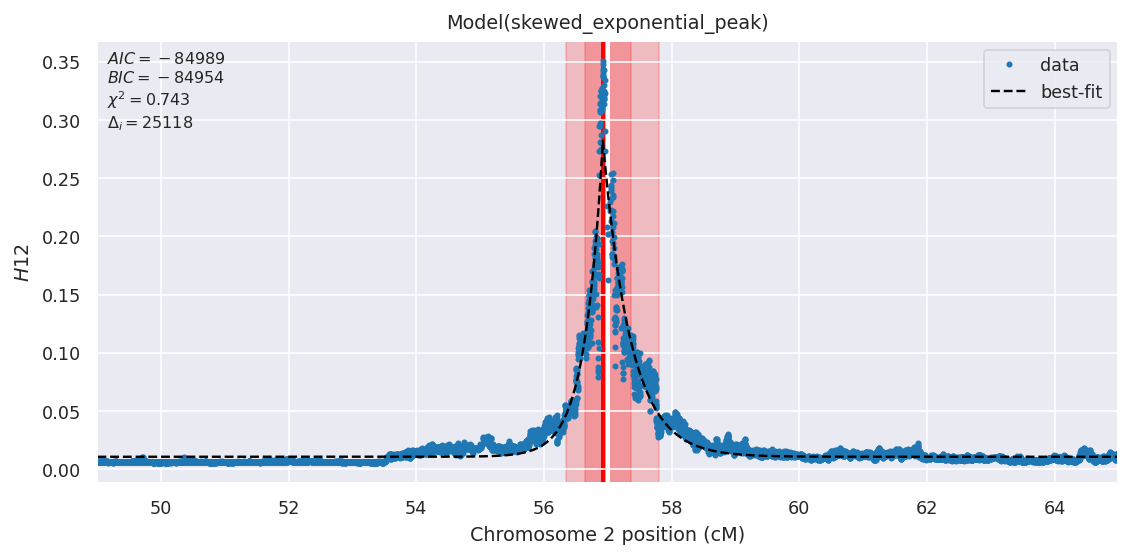

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 133
    # data points      = 9037
    # variables        = 5
    chi-square         = 0.74333195
    reduced chi-square = 8.2300e-05
    Akaike info crit   = -84989.2667
    Bayesian info crit = -84953.7213
[[Variables]]
    center:     56.9219210 +/- 0.00130757 (0.00%) (init = 57)
    amplitude:  0.27146743 +/- 0.00105047 (0.39%) (init = 0.5)
    decay:      0.35315698 +/- 0.00185355 (0.52%) (init = 0.5)
    skew:      -0.30433567 +/- 0.00721068 (2.37%) (init = 0)
    baseline:   0.01074976 +/- 1.0520e-04 (0.98%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.723
    C(amplitude, decay)  = -0.672
    C(decay, baseline)   = -0.305
    C(center, amplitude) =  0.208
    C(decay, skew)       =  0.171
    C(amplitude, skew)   =  0.105
34458466 None


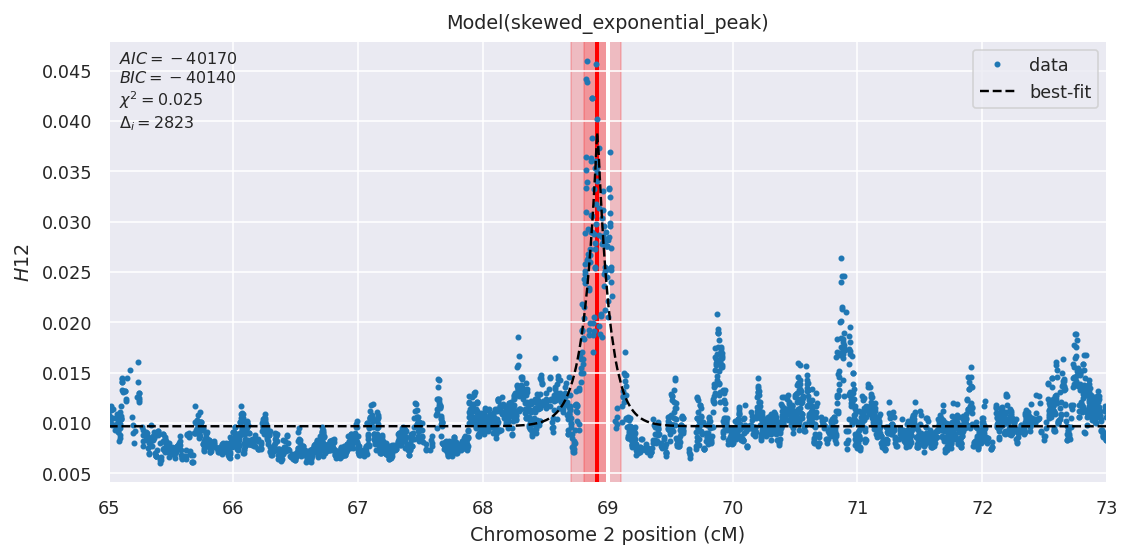

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 147
    # data points      = 3397
    # variables        = 5
    chi-square         = 0.02478527
    reduced chi-square = 7.3070e-06
    Akaike info crit   = -40170.2376
    Bayesian info crit = -40139.5844
[[Variables]]
    center:     68.9169339 +/- 0.00224412 (0.00%) (init = 69)
    amplitude:  0.03000000 +/- 0.00130466 (4.35%) (init = 0.5)
    decay:      0.10054426 +/- 0.00324267 (3.23%) (init = 0.5)
    skew:       0.07144795 +/- 0.04584614 (64.17%) (init = 0)
    baseline:   0.00966322 +/- 4.8693e-05 (0.50%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.751
    C(amplitude, decay)  =  0.736
    C(center, amplitude) = -0.323
    C(decay, skew)       = -0.291
    C(center, decay)     = -0.271
    C(amplitude, skew)   = -0.239
    C(decay, baseline)   =

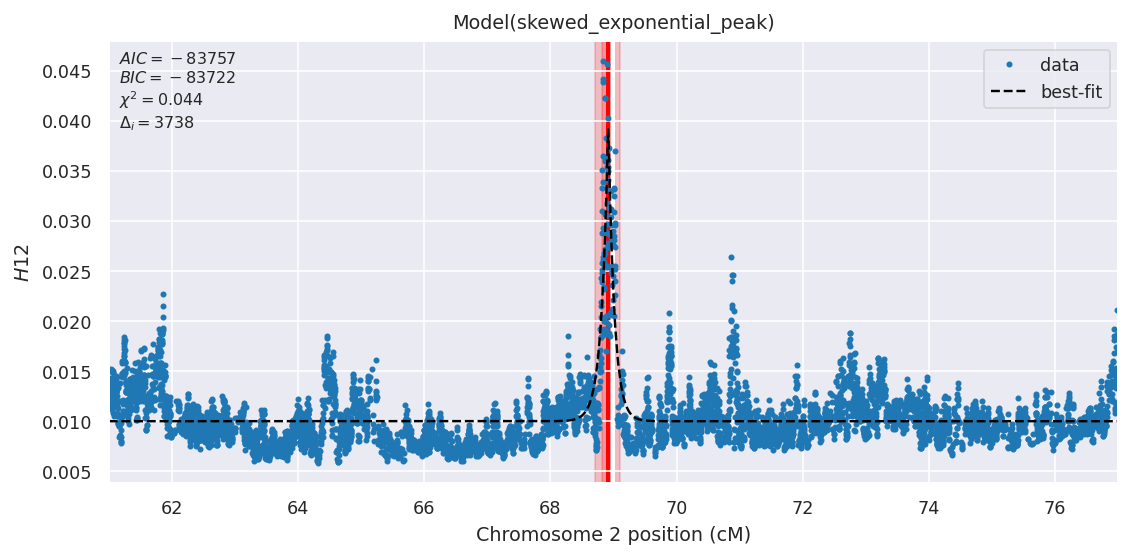

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 7000
    # variables        = 5
    chi-square         = 0.04446806
    reduced chi-square = 6.3571e-06
    Akaike info crit   = -83756.5470
    Bayesian info crit = -83722.2786
[[Variables]]
    center:     68.9170647 +/- 0.00208327 (0.00%) (init = 69)
    amplitude:  0.03000000 +/- 1.2334e-04 (0.41%) (init = 0.5)
    decay:      0.10000002 +/- 0.00240334 (2.40%) (init = 0.5)
    skew:       0.06333029 +/- 0.04281069 (67.60%) (init = 0)
    baseline:   0.01000934 +/- 3.0833e-05 (0.31%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.751
    C(amplitude, decay)  =  0.744
    C(center, amplitude) = -0.318
    C(decay, skew)       = -0.285
    C(center, decay)     = -0.264
    C(amplitude, skew)   = -0.236
    C(decay, baseline)   =

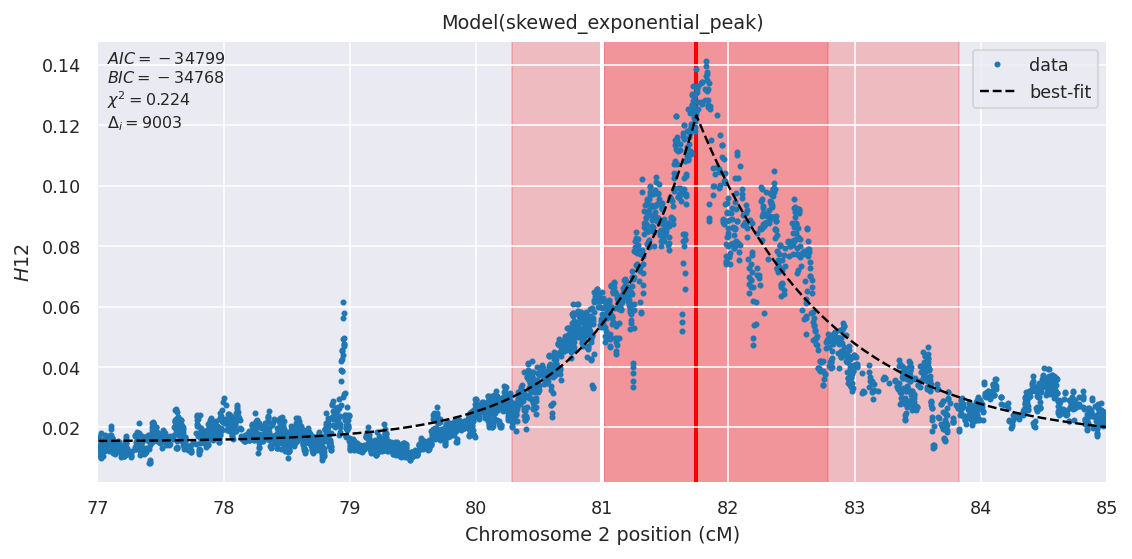

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 3595
    # variables        = 5
    chi-square         = 0.22417478
    reduced chi-square = 6.2444e-05
    Akaike info crit   = -34799.0497
    Bayesian info crit = -34768.1132
[[Variables]]
    center:     81.7461361 +/- 0.00482991 (0.01%) (init = 81)
    amplitude:  0.10788523 +/- 6.3523e-04 (0.59%) (init = 0.5)
    decay:      0.87269256 +/- 0.00980455 (1.12%) (init = 0.5)
    skew:      -0.25548880 +/- 0.01152131 (4.51%) (init = 0)
    baseline:   0.01536179 +/- 2.4438e-04 (1.59%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.719
    C(decay, baseline)   = -0.707
    C(amplitude, decay)  = -0.440
    C(center, amplitude) =  0.334
    C(amplitude, skew)   =  0.276
    C(skew, baseline)    = -0.104
40862619 B


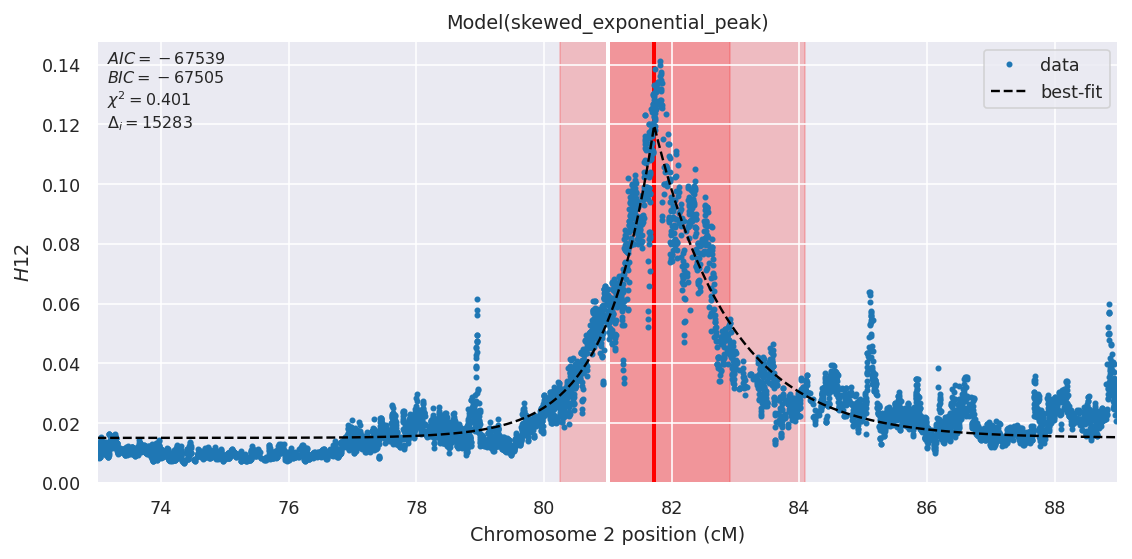

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 6924
    # variables        = 5
    chi-square         = 0.40132245
    reduced chi-square = 5.8003e-05
    Akaike info crit   = -67538.7367
    Bayesian info crit = -67504.5230
[[Variables]]
    center:     81.7252390 +/- 0.00471728 (0.01%) (init = 81)
    amplitude:  0.10461125 +/- 5.5860e-04 (0.53%) (init = 0.5)
    decay:      0.93657997 +/- 0.00821964 (0.88%) (init = 0.5)
    skew:      -0.34005389 +/- 0.01037509 (3.05%) (init = 0)
    baseline:   0.01504879 +/- 1.2754e-04 (0.85%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.699
    C(decay, baseline)   = -0.574
    C(amplitude, decay)  = -0.568
    C(center, amplitude) =  0.246
    C(amplitude, skew)   =  0.179
40868641 B


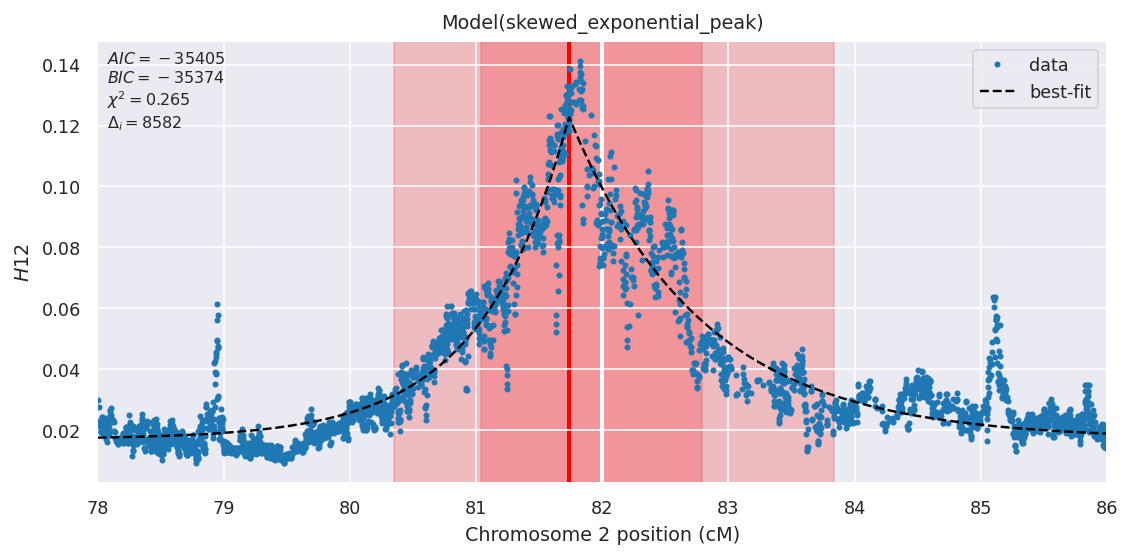

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 3709
    # variables        = 5
    chi-square         = 0.26451555
    reduced chi-square = 7.1413e-05
    Akaike info crit   = -35404.9148
    Bayesian info crit = -35373.8222
[[Variables]]
    center:     81.7372821 +/- 0.00505294 (0.01%) (init = 82)
    amplitude:  0.10578838 +/- 6.6495e-04 (0.63%) (init = 0.5)
    decay:      0.85385953 +/- 0.01108205 (1.30%) (init = 0.5)
    skew:      -0.29849467 +/- 0.01216726 (4.08%) (init = 0)
    baseline:   0.01702571 +/- 2.7252e-04 (1.60%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)   = -0.760
    C(center, skew)      =  0.707
    C(amplitude, decay)  = -0.430
    C(center, amplitude) =  0.289
    C(amplitude, skew)   =  0.220
40865771 B


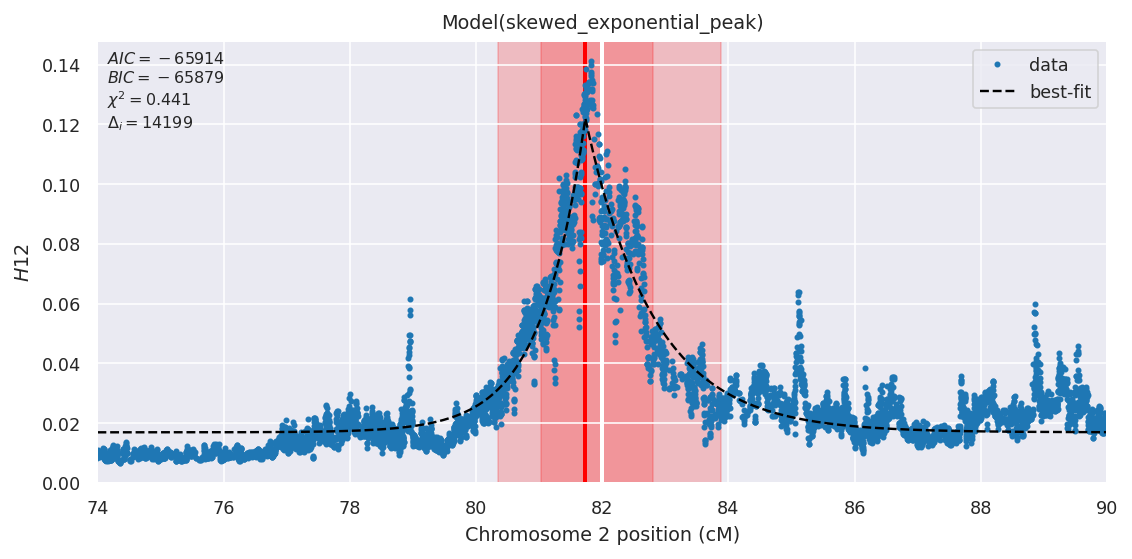

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 6833
    # variables        = 5
    chi-square         = 0.44117559
    reduced chi-square = 6.4613e-05
    Akaike info crit   = -65913.6320
    Bayesian info crit = -65879.4844
[[Variables]]
    center:     81.7315432 +/- 0.00480908 (0.01%) (init = 82)
    amplitude:  0.10514854 +/- 6.1961e-04 (0.59%) (init = 0.5)
    decay:      0.86580770 +/- 0.00823752 (0.95%) (init = 0.5)
    skew:      -0.31761273 +/- 0.01142815 (3.60%) (init = 0)
    baseline:   0.01691257 +/- 1.3202e-04 (0.78%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.702
    C(amplitude, decay)  = -0.586
    C(decay, baseline)   = -0.555
    C(center, amplitude) =  0.267
    C(amplitude, skew)   =  0.199
47167110 None


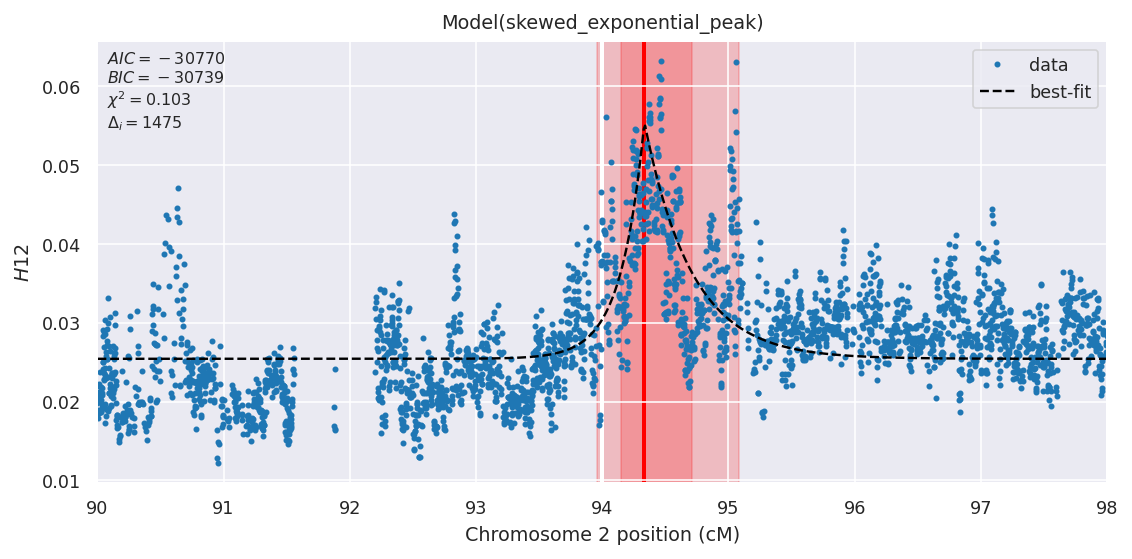

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 209
    # data points      = 2994
    # variables        = 5
    chi-square         = 0.10269080
    reduced chi-square = 3.4356e-05
    Akaike info crit   = -30769.5126
    Bayesian info crit = -30739.4908
[[Variables]]
    center:     94.3342203 +/- 0.00658180 (0.01%) (init = 94)
    amplitude:  0.03000000 +/- 0.00306714 (10.22%) (init = 0.5)
    decay:      0.26389996 +/- 0.01137609 (4.31%) (init = 0.5)
    skew:      -0.49999998 +/- 0.05250085 (10.50%) (init = 0)
    baseline:   0.02542969 +/- 1.2915e-04 (0.51%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.722
    C(amplitude, decay) =  0.620
    C(decay, baseline)  = -0.410
    C(decay, skew)      =  0.337
    C(center, decay)    =  0.240
47167322 None


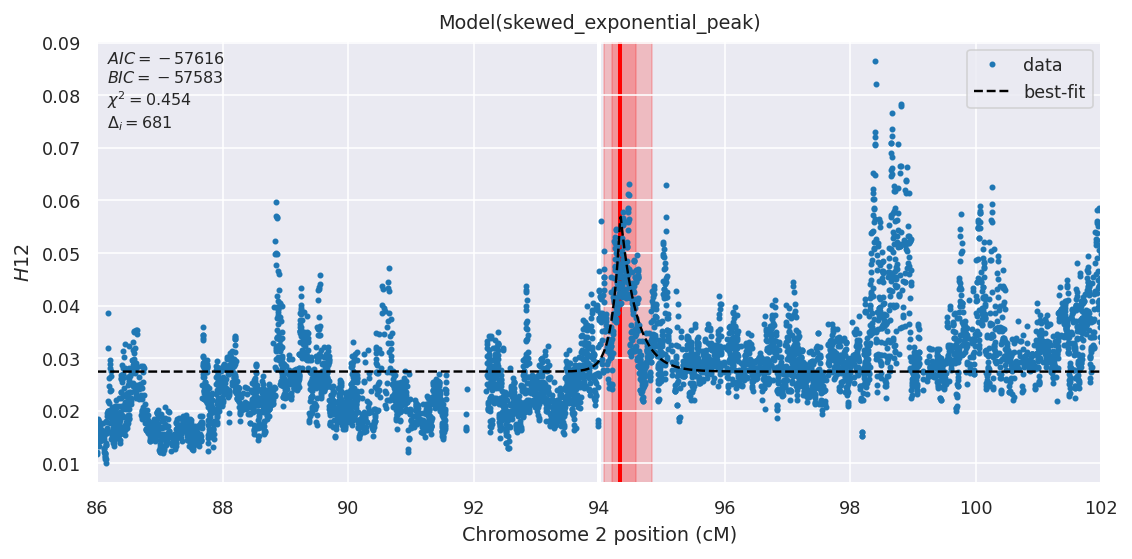

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 160
    # data points      = 6066
    # variables        = 5
    chi-square         = 0.45411009
    reduced chi-square = 7.4923e-05
    Akaike info crit   = -57616.2133
    Bayesian info crit = -57582.6610
[[Variables]]
    center:     94.3346441 +/- 0.00834468 (0.01%) (init = 94)
    amplitude:  0.03000002 +/- 0.01102078 (36.74%) (init = 0.5)
    decay:      0.17951237 +/- 0.01311732 (7.31%) (init = 0.5)
    skew:      -0.49994973 +/- 0.13792725 (27.59%) (init = 0)
    baseline:   0.02746478 +/- 1.1751e-04 (0.43%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.746
    C(amplitude, decay) =  0.680
    C(decay, skew)      =  0.409
    C(center, decay)    =  0.316
    C(decay, baseline)  = -0.214
49338567 None


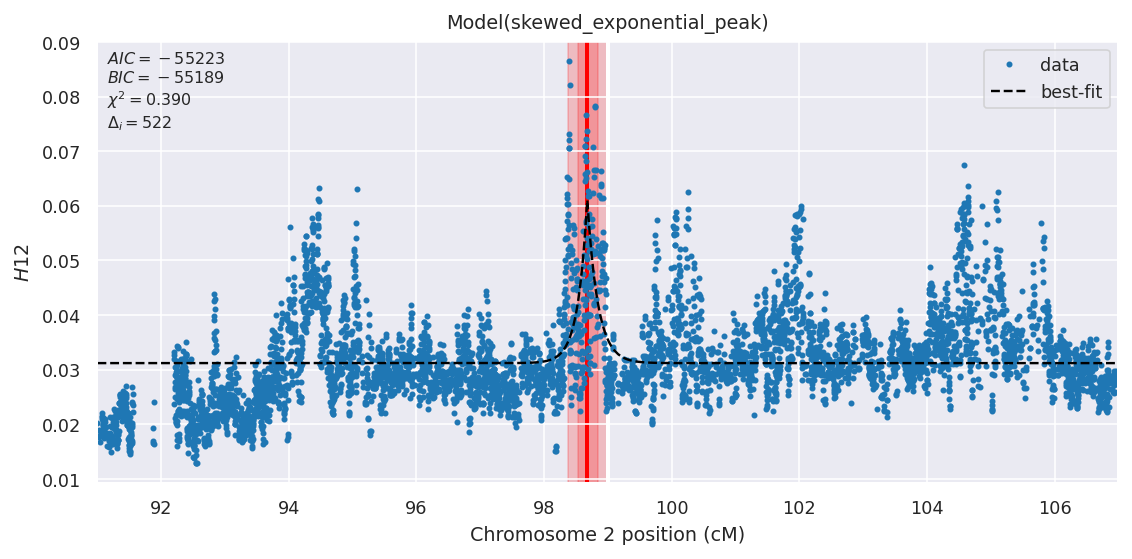

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 5754
    # variables        = 5
    chi-square         = 0.39009522
    reduced chi-square = 6.7854e-05
    Akaike info crit   = -55222.7321
    Bayesian info crit = -55189.4438
[[Variables]]
    center:     98.6771358 +/- 0.00687072 (0.01%) (init = 99)
    amplitude:  0.03000000 +/- 0.00131987 (4.40%) (init = 0.5)
    decay:      0.15657142 +/- 0.01077468 (6.88%) (init = 0.5)
    skew:      -0.08600891 +/- 0.09719337 (113.00%) (init = 0)
    baseline:   0.03120814 +/- 1.1338e-04 (0.36%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.668
    C(amplitude, decay) = -0.650
    C(decay, baseline)  = -0.204
55920390 None


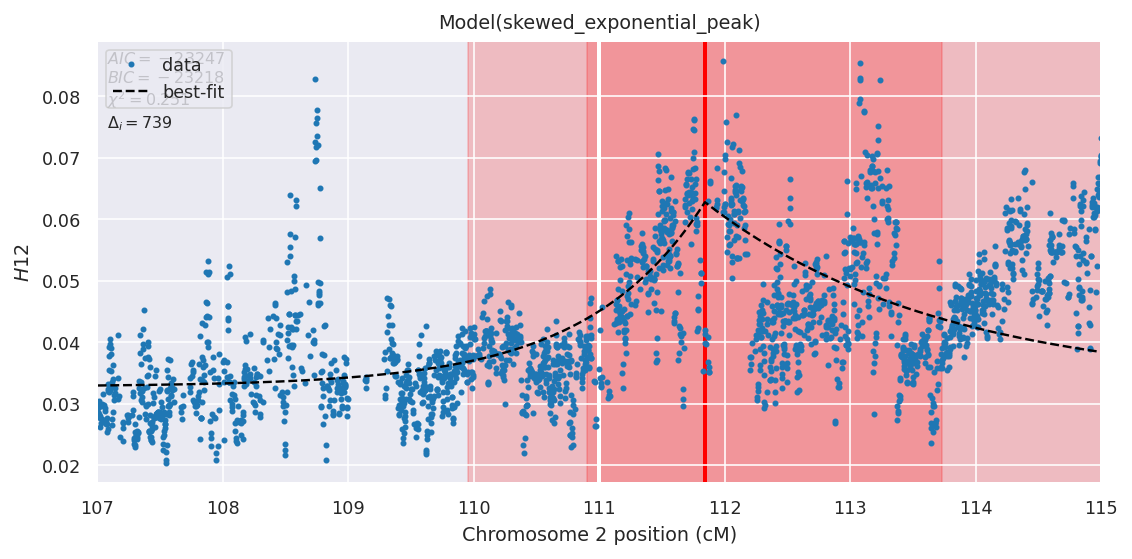

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1530
    # data points      = 2524
    # variables        = 5
    chi-square         = 0.25140387
    reduced chi-square = 9.9803e-05
    Akaike info crit   = -23246.8801
    Bayesian info crit = -23217.7121
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    skew:       at boundary
[[Variables]]
    center:     111.840780 (init = 111)
    amplitude:  0.03000000 (init = 0.5)
    decay:      1.33326683 (init = 0.5)
    skew:      -0.50000000 (init = 0)
    baseline:   0.03279716 (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
63840524 Vgsc


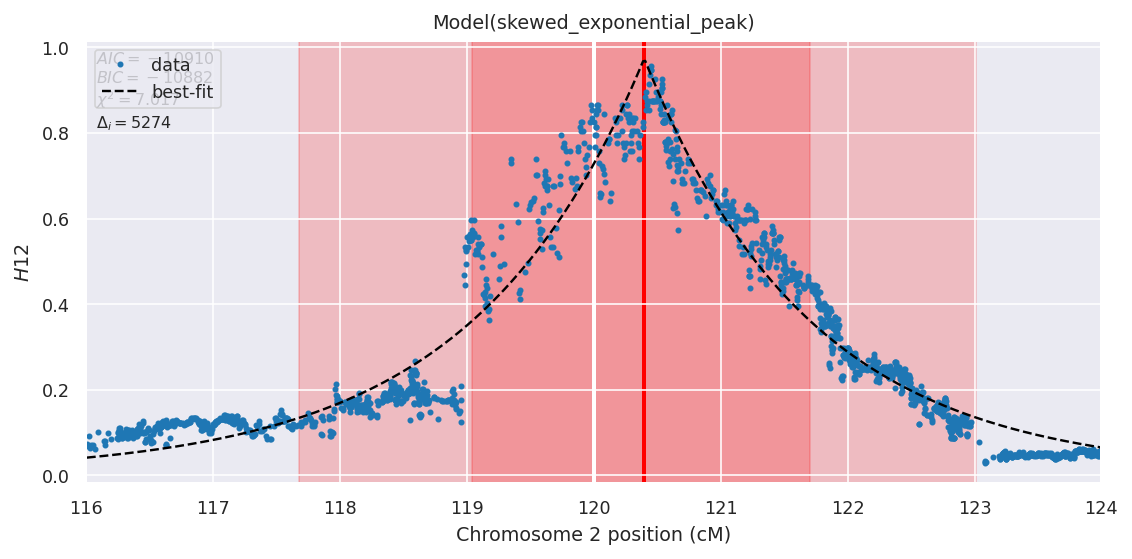

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 1942
    # variables        = 5
    chi-square         = 7.01713904
    reduced chi-square = 0.00362268
    Akaike info crit   = -10910.0953
    Bayesian info crit = -10882.2379
[[Variables]]
    center:     120.397428 +/- 0.00755682 (0.01%) (init = 120)
    amplitude:  0.97061175 +/- 0.00596186 (0.61%) (init = 0.5)
    decay:      1.33333333 +/- 0.02301122 (1.73%) (init = 0.5)
    skew:       0.02674205 +/- 0.01052234 (39.35%) (init = 0)
    baseline:   0.00320076 +/- 0.00514867 (160.86%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)     = -0.908
    C(center, skew)        =  0.720
    C(amplitude, baseline) = -0.379
    C(center, amplitude)   = -0.162
    C(decay, skew)         =  0.157
63844055 Vgsc


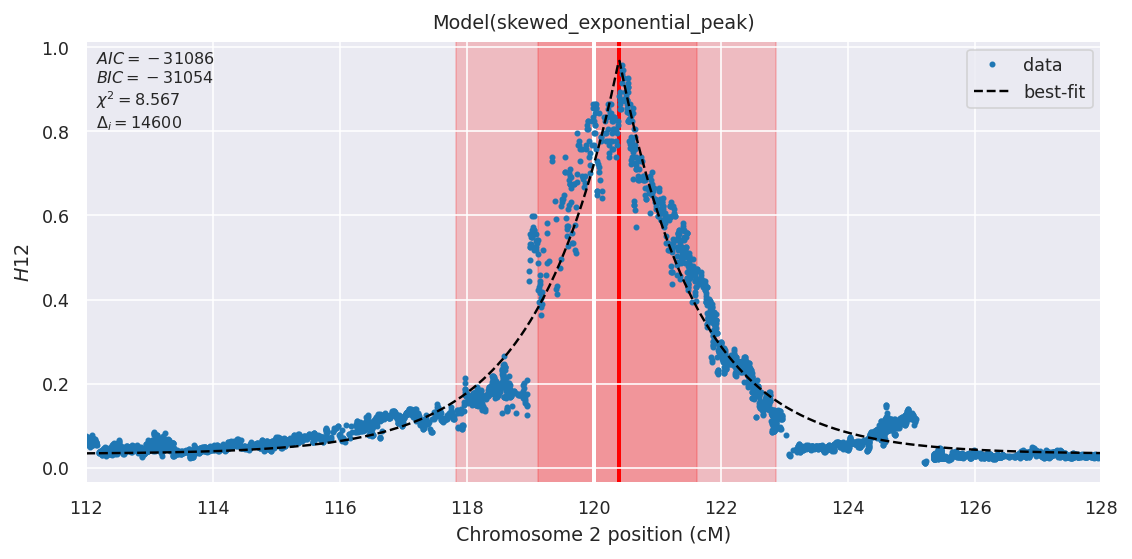

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 4898
    # variables        = 5
    chi-square         = 8.56655466
    reduced chi-square = 0.00175078
    Akaike info crit   = -31086.0140
    Bayesian info crit = -31053.5310
[[Variables]]
    center:     120.399193 +/- 0.00516541 (0.00%) (init = 120)
    amplitude:  0.93872687 +/- 0.00386740 (0.41%) (init = 0.5)
    decay:      1.25968575 +/- 0.00815780 (0.65%) (init = 0.5)
    skew:       0.02922050 +/- 0.00732649 (25.07%) (init = 0)
    baseline:   0.03313515 +/- 8.8835e-04 (2.68%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.703
    C(decay, baseline)   = -0.621
    C(amplitude, decay)  = -0.574
    C(center, amplitude) = -0.208
    C(decay, skew)       =  0.167
    C(amplitude, skew)   = -0.142
    C(center, decay)     =

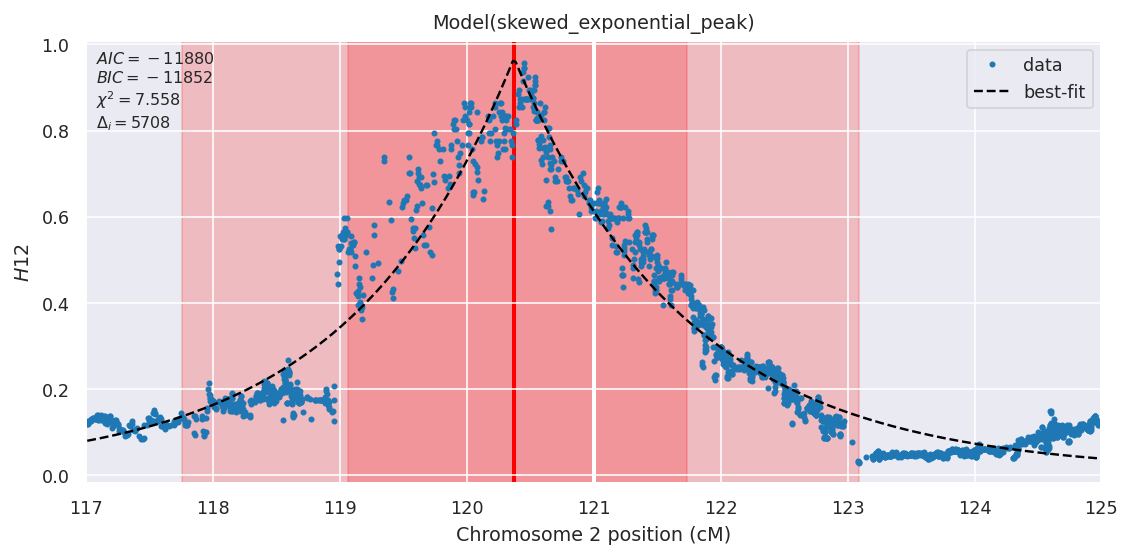

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 2111
    # variables        = 5
    chi-square         = 7.55808150
    reduced chi-square = 0.00358883
    Akaike info crit   = -11879.7846
    Bayesian info crit = -11851.5100
[[Variables]]
    center:     120.371469 +/- 0.00769377 (0.01%) (init = 121)
    amplitude:  0.96136883 +/- 0.00575434 (0.60%) (init = 0.5)
    decay:      1.33333329 +/- 0.00384361 (0.29%) (init = 0.5)
    skew:      -0.02888772 +/- 0.01090901 (37.76%) (init = 0)
    baseline:   0.00707815 +/- 0.00430278 (60.79%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)     =  0.875
    C(center, skew)        =  0.725
    C(amplitude, baseline) = -0.307
    C(center, amplitude)   = -0.211
    C(amplitude, skew)     = -0.193
    C(skew, baseline)      =  0.188
    C(center,

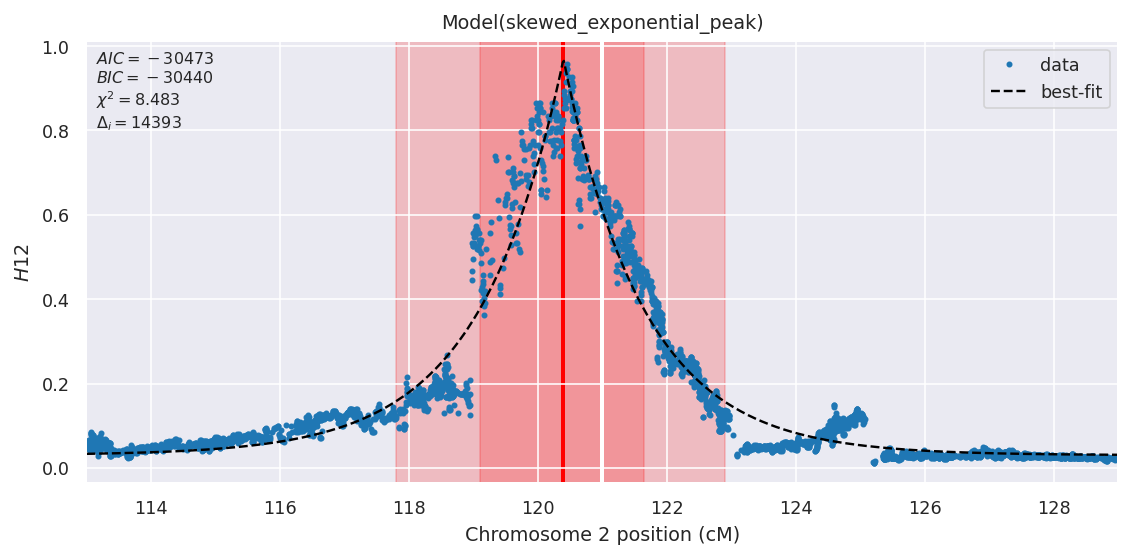

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 4808
    # variables        = 5
    chi-square         = 8.48314577
    reduced chi-square = 0.00176622
    Akaike info crit   = -30472.5043
    Bayesian info crit = -30440.1141
[[Variables]]
    center:     120.399384 +/- 0.00522020 (0.00%) (init = 121)
    amplitude:  0.93913374 +/- 0.00386319 (0.41%) (init = 0.5)
    decay:      1.27507985 +/- 0.00830431 (0.65%) (init = 0.5)
    skew:       0.02969367 +/- 0.00731094 (24.62%) (init = 0)
    baseline:   0.03004512 +/- 9.1421e-04 (3.04%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.704
    C(decay, baseline)   = -0.628
    C(amplitude, decay)  = -0.569
    C(center, amplitude) = -0.208
    C(decay, skew)       =  0.155
    C(amplitude, skew)   = -0.143
87013974 Gaba


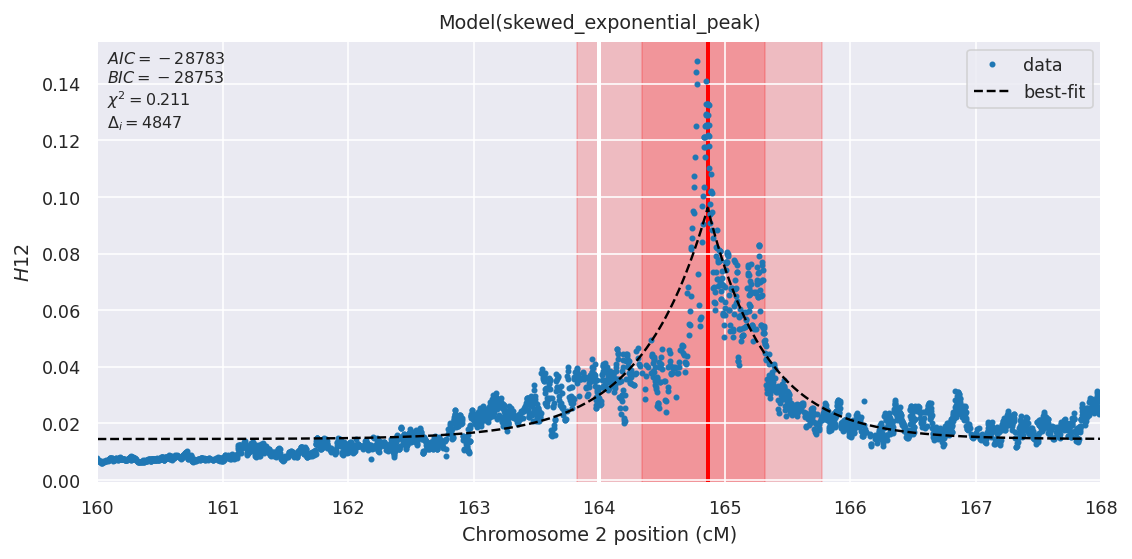

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 256
    # data points      = 3010
    # variables        = 5
    chi-square         = 0.21092915
    reduced chi-square = 7.0193e-05
    Akaike info crit   = -28783.4444
    Bayesian info crit = -28753.3959
[[Variables]]
    center:     164.862587 +/- 0.00535997 (0.00%) (init = 164)
    amplitude:  0.08172426 +/- 9.0659e-04 (1.11%) (init = 0.5)
    decay:      0.48811823 +/- 0.00910594 (1.87%) (init = 0.5)
    skew:       0.09572126 +/- 0.02223792 (23.23%) (init = 0)
    baseline:   0.01445861 +/- 2.0909e-04 (1.45%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.673
    C(decay, baseline)   = -0.564
    C(amplitude, decay)  = -0.548
    C(center, amplitude) = -0.154
87009644 Gaba


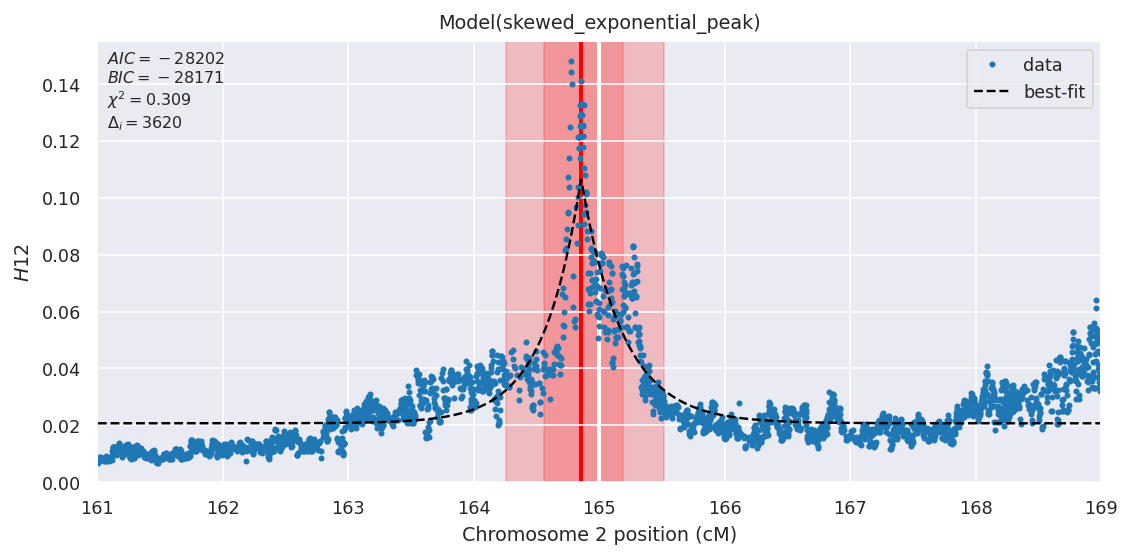

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 3066
    # variables        = 5
    chi-square         = 0.30935075
    reduced chi-square = 1.0106e-04
    Akaike info crit   = -28201.5187
    Bayesian info crit = -28171.3781
[[Variables]]
    center:     164.853927 +/- 0.00485770 (0.00%) (init = 165)
    amplitude:  0.08605524 +/- 0.00131779 (1.53%) (init = 0.5)
    decay:      0.31449473 +/- 0.00784901 (2.50%) (init = 0.5)
    skew:      -0.07195509 +/- 0.03285936 (45.67%) (init = 0)
    baseline:   0.02071185 +/- 2.1392e-04 (1.03%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.659
    C(amplitude, decay)  = -0.596
    C(decay, baseline)   = -0.409
    C(decay, skew)       =  0.199
    C(center, amplitude) = -0.170
    C(center, decay)     =  0.110
90094883 C


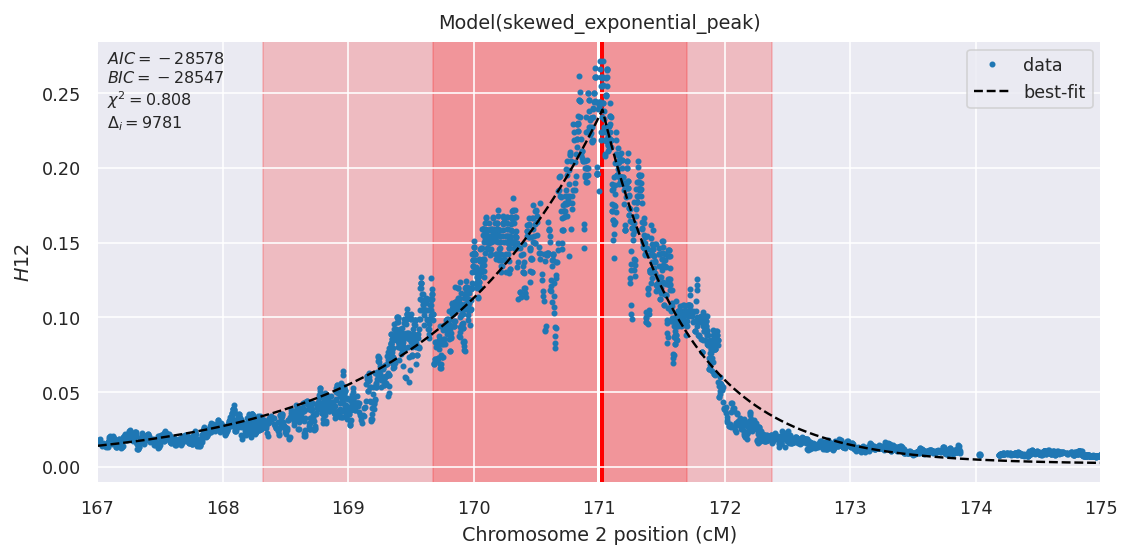

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 3423
    # variables        = 5
    chi-square         = 0.80777106
    reduced chi-square = 2.3633e-04
    Akaike info crit   = -28578.0377
    Bayesian info crit = -28547.3463
[[Variables]]
    center:     171.024405 +/- 0.00394410 (0.00%) (init = 171)
    amplitude:  0.23718069 +/- 0.00104792 (0.44%) (init = 0.5)
    decay:      0.95611190 +/- 0.01002706 (1.05%) (init = 0.5)
    skew:       0.50000000 +/- 7.5156e-07 (0.00%) (init = 0)
    baseline:   0.00185253 +/- 6.1049e-04 (32.95%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)     = -0.784
    C(center, skew)        = -0.717
    C(decay, skew)         =  0.283
    C(amplitude, baseline) = -0.232
    C(amplitude, decay)    = -0.224
    C(center, decay)       = -0.160
    C(skew, ba

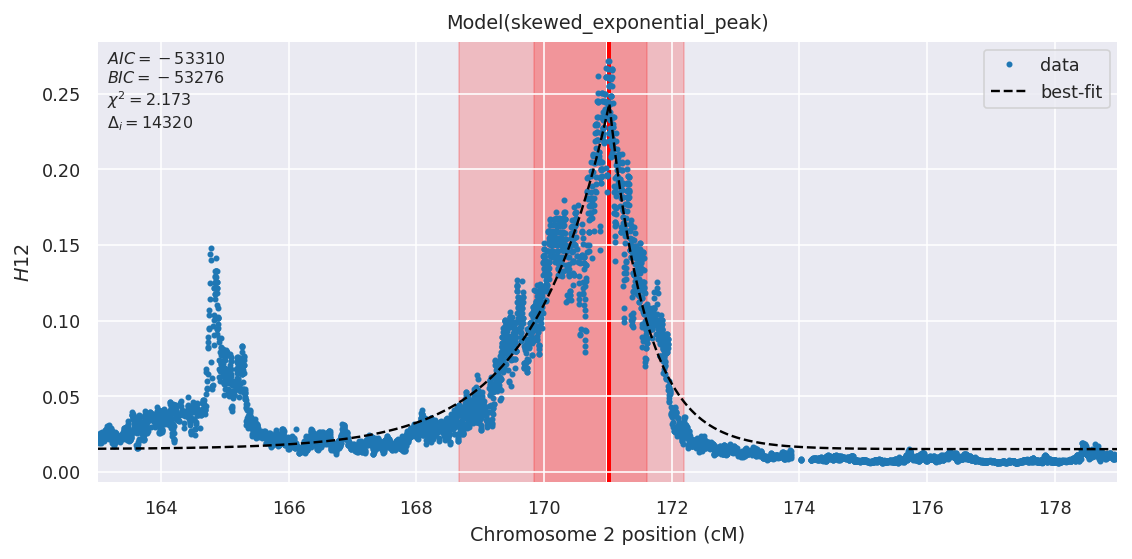

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 6644
    # variables        = 5
    chi-square         = 2.17305286
    reduced chi-square = 3.2732e-04
    Akaike info crit   = -53310.3353
    Bayesian info crit = -53276.3280
[[Variables]]
    center:     171.023434 +/- 0.00443686 (0.00%) (init = 171)
    amplitude:  0.22840069 +/- 0.00126908 (0.56%) (init = 0.5)
    decay:      0.83160768 +/- 0.00799955 (0.96%) (init = 0.5)
    skew:       0.49999998 +/- 0.01198537 (2.40%) (init = 0)
    baseline:   0.01501623 +/- 2.9984e-04 (2.00%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.710
    C(amplitude, decay)  = -0.557
    C(decay, baseline)   = -0.504
    C(decay, skew)       = -0.270
    C(center, decay)     = -0.154
    C(center, amplitude) = -0.114
90094657 C


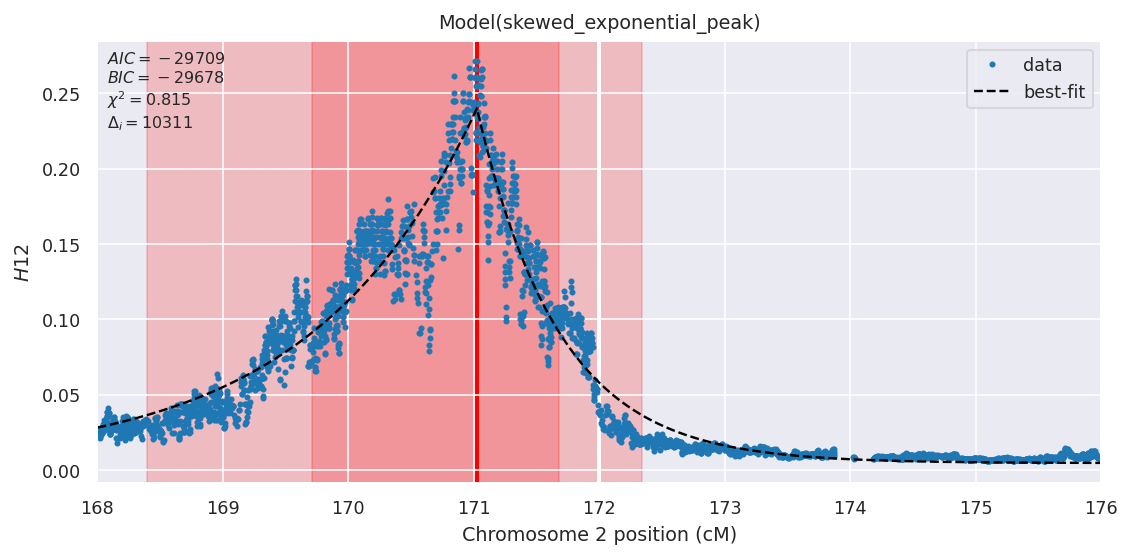

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 3547
    # variables        = 5
    chi-square         = 0.81492663
    reduced chi-square = 2.3008e-04
    Akaike info crit   = -29708.5914
    Bayesian info crit = -29677.7222
[[Variables]]
    center:     171.023953 +/- 0.00391266 (0.00%) (init = 172)
    amplitude:  0.23542314 +/- 0.00106251 (0.45%) (init = 0.5)
    decay:      0.92890002 +/- 0.00838019 (0.90%) (init = 0.5)
    skew:       0.49999977 +/- 0.00984155 (1.97%) (init = 0)
    baseline:   0.00462029 +/- 4.6265e-04 (10.01%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)        =  0.725
    C(decay, baseline)     = -0.665
    C(amplitude, decay)    = -0.359
    C(decay, skew)         = -0.271
    C(amplitude, baseline) = -0.213
    C(skew, baseline)      =  0.185
    C(center, 

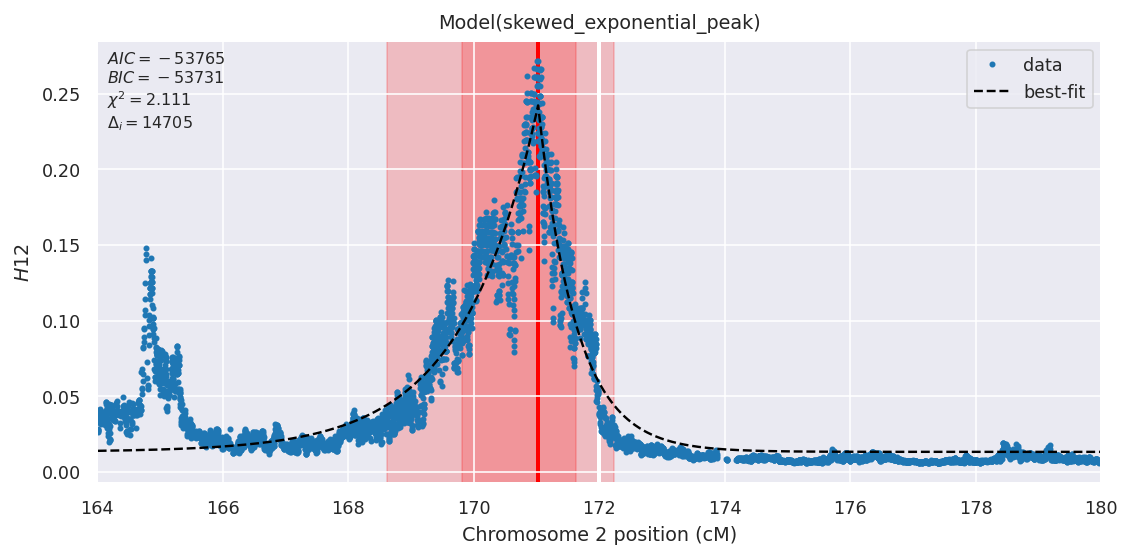

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 6673
    # variables        = 5
    chi-square         = 2.11124226
    reduced chi-square = 3.1662e-04
    Akaike info crit   = -53764.6928
    Bayesian info crit = -53730.6636
[[Variables]]
    center:     171.023349 +/- 0.00440804 (0.00%) (init = 172)
    amplitude:  0.22908266 +/- 0.00123375 (0.54%) (init = 0.5)
    decay:      0.85264675 +/- 0.00796180 (0.93%) (init = 0.5)
    skew:       0.50000000 +/- 7.4036e-04 (0.15%) (init = 0)
    baseline:   0.01320646 +/- 2.9487e-04 (2.23%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = -0.710
    C(amplitude, decay)  = -0.554
    C(decay, baseline)   = -0.504
    C(decay, skew)       =  0.272
    C(center, decay)     = -0.155
    C(center, amplitude) = -0.114
103987763 None


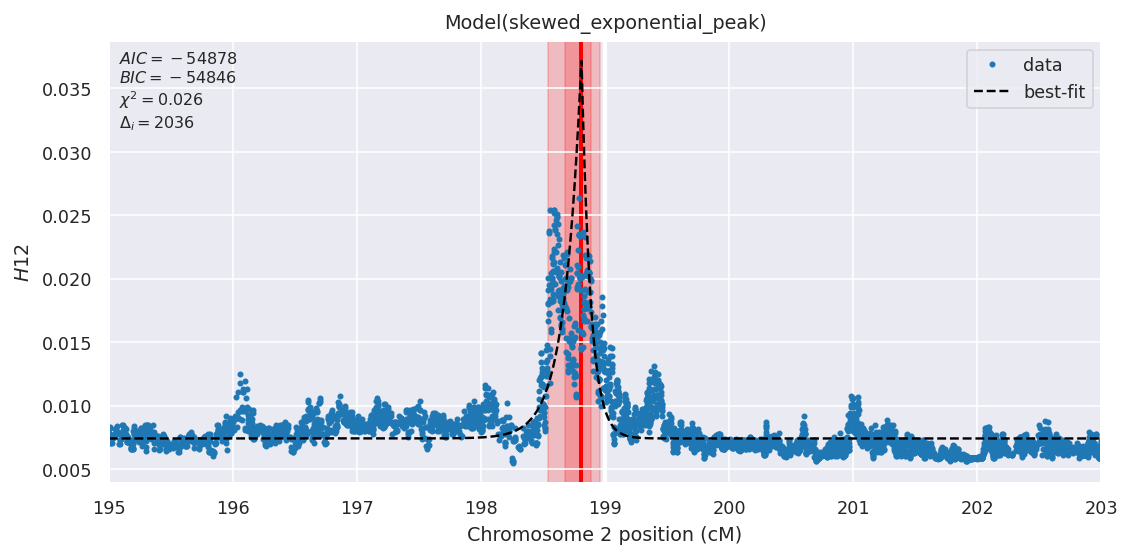

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 541
    # data points      = 4542
    # variables        = 5
    chi-square         = 0.02564430
    reduced chi-square = 5.6523e-06
    Akaike info crit   = -54878.0572
    Bayesian info crit = -54845.9516
[[Variables]]
    center:     198.810163 +/- 0.00137015 (0.00%) (init = 199)
    amplitude:  0.03000000 +/- 4.4723e-04 (1.49%) (init = 0.5)
    decay:      0.10000069 +/- 0.00194340 (1.94%) (init = 0.5)
    skew:       0.44852834 +/- 0.02876922 (6.41%) (init = 0)
    baseline:   0.00741985 +/- 3.7481e-05 (0.51%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.717
    C(amplitude, decay) =  0.665
    C(decay, skew)      = -0.271
    C(decay, baseline)  = -0.232
    C(center, decay)    = -0.196
103989822 None


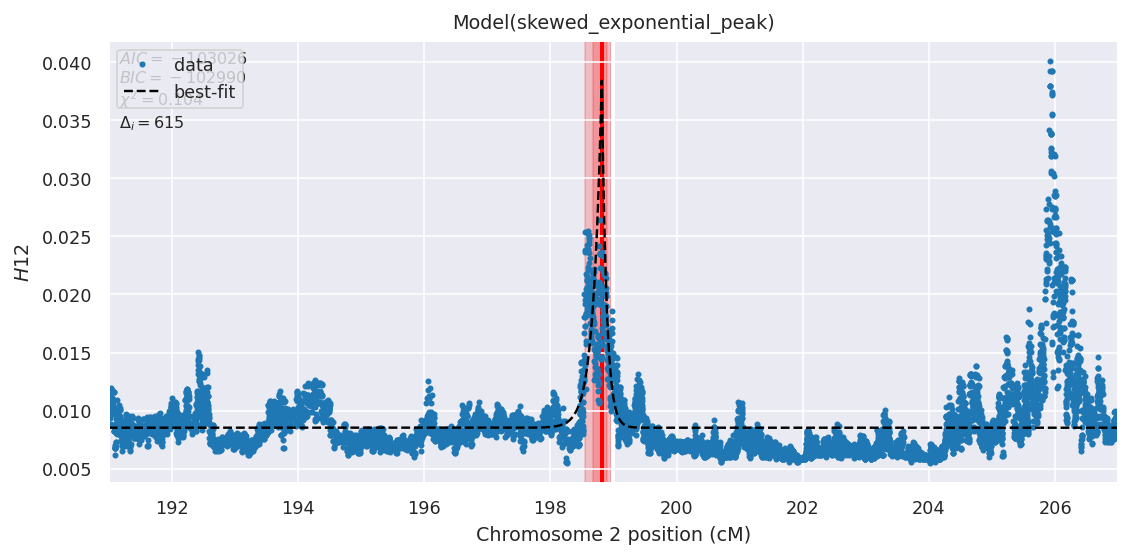

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 243
    # data points      = 9058
    # variables        = 5
    chi-square         = 0.10396098
    reduced chi-square = 1.1484e-05
    Akaike info crit   = -103026.048
    Bayesian info crit = -102990.491
[[Variables]]
    center:     198.814282 +/- 0.00197336 (0.00%) (init = 199)
    amplitude:  0.03000000 +/- 3.8644e-05 (0.13%) (init = 0.5)
    decay:      0.10000000 +/- 0.00243349 (2.43%) (init = 0.5)
    skew:       0.40852293 +/- 0.04098819 (10.03%) (init = 0)
    baseline:   0.00852264 +/- 3.6673e-05 (0.43%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.720
    C(amplitude, decay) =  0.682
    C(decay, skew)      = -0.265
    C(center, decay)    = -0.200
    C(decay, baseline)  = -0.163
107542418 None


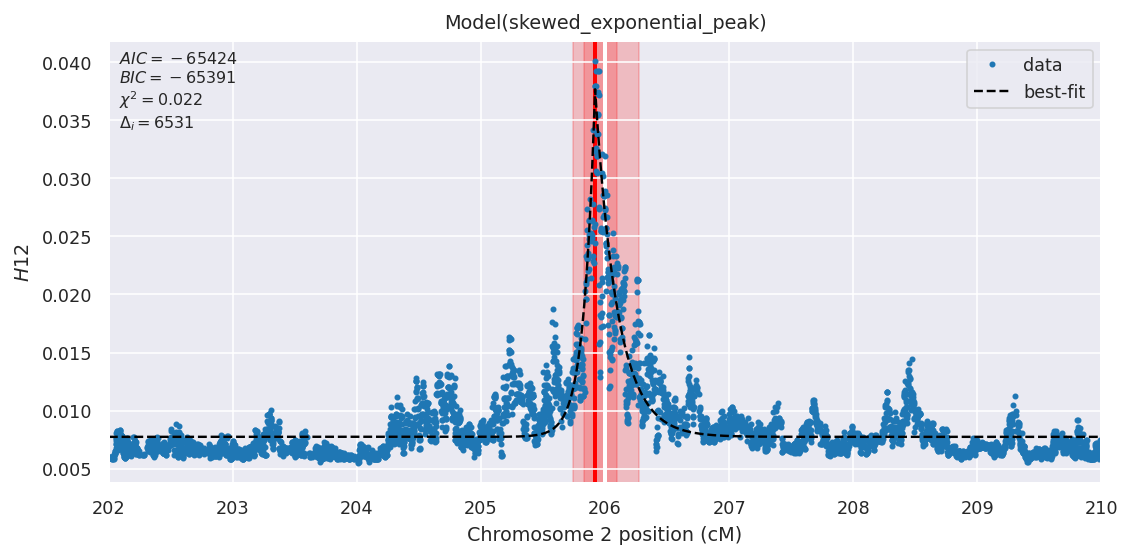

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 975
    # data points      = 5278
    # variables        = 5
    chi-square         = 0.02179305
    reduced chi-square = 4.1330e-06
    Akaike info crit   = -65423.8282
    Bayesian info crit = -65390.9717
[[Variables]]
    center:     205.919474 +/- 0.00147727 (0.00%) (init = 206)
    amplitude:  0.03000000 +/- 2.4855e-05 (0.08%) (init = 0.5)
    decay:      0.12664705 +/- 0.00205984 (1.63%) (init = 0.5)
    skew:      -0.49935742 +/- 0.02261555 (4.53%) (init = 0)
    baseline:   0.00773778 +/- 3.0172e-05 (0.39%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.731
    C(amplitude, decay)  = -0.680
    C(decay, skew)       =  0.418
    C(center, decay)     =  0.364
    C(decay, baseline)   = -0.255
    C(center, amplitude) = -0.241
    C(amplitude, skew)   =

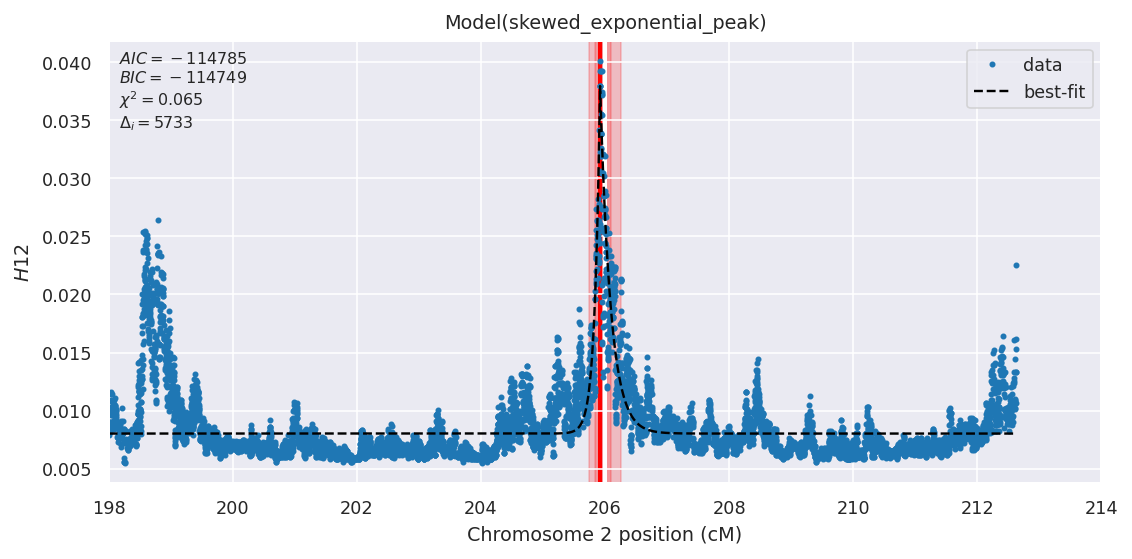

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 482
    # data points      = 9646
    # variables        = 5
    chi-square         = 0.06544960
    reduced chi-square = 6.7887e-06
    Akaike info crit   = -114784.862
    Bayesian info crit = -114748.990
[[Variables]]
    center:     205.919463 +/- 0.00185194 (0.00%) (init = 206)
    amplitude:  0.03000000 +/- 3.9636e-04 (1.32%) (init = 0.5)
    decay:      0.12055423 +/- 0.00253496 (2.10%) (init = 0.5)
    skew:      -0.49937156 +/- 0.02932495 (5.87%) (init = 0)
    baseline:   0.00802070 +/- 2.7552e-05 (0.34%) (init = 0.00951087)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.731
    C(amplitude, decay)  =  0.690
    C(decay, skew)       =  0.424
    C(center, decay)     =  0.369
    C(center, amplitude) =  0.244
    C(decay, baseline)   = -0.181
    C(amplitude, skew)   =

In [91]:
df_peaks = peak_scan('bf_gam', '2', diagnostics=True)

In [92]:
df_peaks

pop chromosome     gcenter    pcenter       delta_i   locus  \
0   bf_gam          2    6.824845    3412422   7279.890034    Ace1   
1   bf_gam          2    6.826724    3413361   6964.882380    Ace1   
2   bf_gam          2    6.829372    3414685   7299.870604    Ace1   
3   bf_gam          2    6.827076    3413537   7599.804637    Ace1   
4   bf_gam          2    7.145173    3572586   6606.549083    Ace1   
5   bf_gam          2    7.141731    3570865   7396.826870    Ace1   
6   bf_gam          2   56.921933   28460966  12463.972730  Cyp6p3   
7   bf_gam          2   56.921921   28460960  25495.000701  Cyp6p3   
8   bf_gam          2   56.922125   28461062  12602.696453  Cyp6p3   
9   bf_gam          2   56.921921   28460960  25117.667385  Cyp6p3   
10  bf_gam          2   68.916934   34458466   2822.607307    None   
11  bf_gam          2   68.917065   34458532   3738.316897    None   
12  bf_gam          2   81.746136   40873068   9002.719569       B   
13  bf_gam          2   81.725239   40862619  15283.086075       B   
14  bf_gam          2   81.737282   40868641   8582.016819       B   
15  bf_gam          2   81.731543   40865771  14198.635921       B   
16  bf_gam          2   94.334220   47167110   1475.410762    None   
17  bf_gam          2   94.334644   47167322    681.246136    None   
18  bf_gam          2   98.677136   49338567    522.010690    None   
19  bf_gam          2  111.840780   55920390    738.774732    None   
20  bf_gam          2  120.397428   63840524   5274.093988    Vgsc   
21  bf_gam          2  120.399193   63844055  14600.439522    Vgsc   
22  bf_gam          2  120.371469   63788607   5708.483268    Vgsc   
23  bf_gam          2  120.399384   63844437  14393.074155    Vgsc   
24  bf_gam          2  164.862587   87013974   4847.414294    Gaba   
25  bf_gam          2  164.853927   87009644   3619.555513    Gaba   
26  bf_gam          2  171.024405   90094883   9780.622735       C   
27  bf_gam          2  171.023434   90094398  14320.360873       C   
28  bf_gam          2  171.023953   90094657  10311.277224       C   
29  bf_gam          2  171.023349   90094355  14705.047448       C   
30  bf_gam          2  198.810163  103987763   2035.812575    None   
31  bf_gam          2  198.814282  103989822    614.518376    None   
32  bf_gam          2  205.919474  107542418   6531.459856    None   
33  bf_gam          2  205.919463  107542413   5732.679173    None   

    span1_gstart  span1_gstop  span2_gstart  span2_gstop  ...      skew  \
0       6.342322     7.456901      5.859800     8.088956  ... -0.194728   
1       6.354561     7.441377      5.882399     8.056030  ... -0.190244   
2       6.300969     7.497117      5.772567     8.164862  ... -0.168831   
3       6.348687     7.447395      5.870299     8.067714  ... -0.187414   
4       6.205299     7.615110      5.265426     8.085047  ...  0.500000   
5       6.336514     7.544340      5.531296     7.946948  ...  0.500000   
6      56.652918    57.333185     56.383903    57.744437  ... -0.306169   
7      56.633873    57.361435     56.345825    57.800950  ... -0.304802   
8      56.658121    57.325513     56.394118    57.728902  ... -0.305806   
9      56.635929    57.358017     56.349937    57.794113  ... -0.304336   
10     68.811285    69.012620     68.705636    69.108306  ...  0.071448   
11     68.812577    69.012770     68.708090    69.108475  ...  0.063330   
12     81.015079    82.787904     80.284021    83.829672  ... -0.255489   
13     80.985330    82.910766     80.245421    84.096292  ... -0.340054   
14     81.043009    82.787410     80.348735    83.837538  ... -0.298495   
15     81.036822    82.810570     80.342101    83.889598  ... -0.317613   
16     94.147615    94.707431     93.961009    95.080642  ... -0.500000   
17     94.207705    94.588504     94.080766    94.842364  ... -0.499950   
18     98.529626    98.843325     98.382116    99.009515  ... -0.086009   
19    110.898018   113.726304    109.955256   115.611828

In [95]:
def dedup_peaks(df_peaks):
    
    keep = list(range(len(df_peaks)))
    for i, this in df_peaks.iterrows():
        for j, that in df_peaks.iterrows():
            if i != j:
                # thank you Ned Batchelder
                # https://nedbatchelder.com/blog/201310/range_overlap_in_two_compares.html
                disjoint = that.span1_gstart > this.span1_gstop or that.span1_gstop < this.span1_gstart
                if not disjoint and that.delta_i > this.delta_i:
                    keep.remove(i)
                    break
    return keep
    

In [96]:
keep = dedup_peaks(df_peaks)

In [98]:
df_peaks.iloc[keep].reset_index(drop=True).sort_values('delta_i', ascending=False)

pop chromosome     gcenter    pcenter       delta_i   locus  \
1   bf_gam          2   56.921921   28460960  25495.000701  Cyp6p3   
3   bf_gam          2   81.725239   40862619  15283.086075       B   
9   bf_gam          2  171.023349   90094355  14705.047448       C   
7   bf_gam          2  120.399193   63844055  14600.439522    Vgsc   
0   bf_gam          2    6.827076    3413537   7599.804637    Ace1   
11  bf_gam          2  205.919474  107542418   6531.459856    None   
8   bf_gam          2  164.862587   87013974   4847.414294    Gaba   
2   bf_gam          2   68.917065   34458532   3738.316897    None   
10  bf_gam          2  198.810163  103987763   2035.812575    None   
4   bf_gam          2   94.334220   47167110   1475.410762    None   
6   bf_gam          2  111.840780   55920390    738.774732    None   
5   bf_gam          2   98.677136   49338567    522.010690    None   

    span1_gstart  span1_gstop  span2_gstart  span2_gstop  ...      skew  \
1      56.633873    57.361435     56.345825    57.800950  ... -0.304802   
3      80.985330    82.910766     80.245421    84.096292  ... -0.340054   
9     169.817524   171.626261    168.611700   172.229173  ...  0.500000   
7     119.113734   121.633622    117.828274   122.868051  ...  0.029220   
0       6.348687     7.447395      5.870299     8.067714  ... -0.187414   
11    205.829881   206.098500    205.740288   206.277526  ... -0.499357   
8     164.340984   165.319370    163.819381   165.776153  ...  0.095721   
2      68.812577    69.012770     68.708090    69.108475  ...  0.063330   
10    198.673697   198.883442    198.537232   198.956722  ...  0.448528   
4      94.147615    94.707431     93.961009    95.080642  ... -0.500000   
6     110.898018   113.726304    109.955256   115.611828  ... -0.500000   
5      98.529626    98.843325     98.382116    99.009515  ... -0.086009   

    decay_left  decay_right  baseline            aic            bic       rss  \
1     0.288048     0.439515  0.010386  -86462.771008  -86427.142196  0.752237   
3     0.739909     1.185527  0.015049  -67538.736722  -67504.522977  0.401322   
9     1.205825     0.602912  0.013206  -53764.692752  -53730.663628  2.111242   
7     1.285460     1.234429  0.033135  -31086.013954  -31053.531043  8.566555   
0     0.478388     0.620319  0.007571 -112966.524401 -112930.384973  0.153620   
11    0.089593     0.179026  0.007738  -65423.828204  -65390.971692  0.021793   
8     0.521603     0.456783  0.014459  -28783.444353  -28753.395877  0.210929   
2     0.104488     0.095705  0.010009  -83756.546969  -83722.278642  0.044468   
10    0.136466     0.073280  0.007420  -54878.057229  -54845.951616  0.025644   
4     0.186605     0.373211  0.025430  -30769.512606  -30739.490778  0.102691   
6     0.942762     1.885524  0.032797  -23246.880067  -23217.712066  0.251404   
5     0.147510     0.166190  0.031208  -55222.732102  -55189.443850  0.390095   

     constant_aic                                             params  \
1   -60967.770307  {'center': <Parameter 'center', value=56.92192...   
3   -52255.650647  {'center': <Parameter 'center', value=81.72523...   
9   -39059.645304  {'center': <Parameter 'center', value=171.0233...   
7   -16485.574432  {'center': <Parameter 'center', value=120.3991...   
0  -105366.719764  {'center': <Parameter 'center', value=6.827075...   
11  -58892.368348  {'center': <Parameter 'center', value=205.9194...   
8   -23936.030060  {'center': <Parameter 'center', value=164.8625...   
2   -80018.230072  {'center': <Parameter 'center', value=68.91706...   
10  -52842.244654  {'center': <Parameter 'center', value=198.8101...   
4   -29294.101844  {'center': <Parameter 'center', value=94.33422...   
6   -22508.105335  {'center': <Parameter 'center', value=111.8407...   
5   -54700.721412  {'center': <Parameter 'center', value=98.67713...   

                                               result  
1   <lmfit.model.ModelResult object at 0x7fa847812...  
3   <lmfit.model.

max_baseline 0.019911111111111112


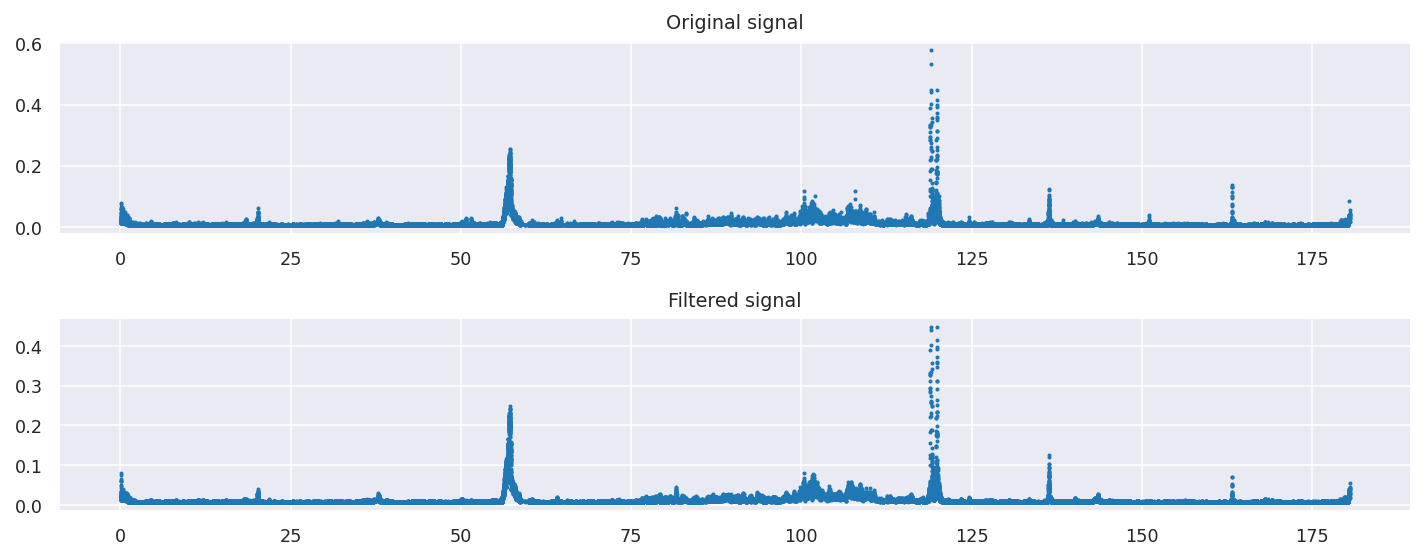

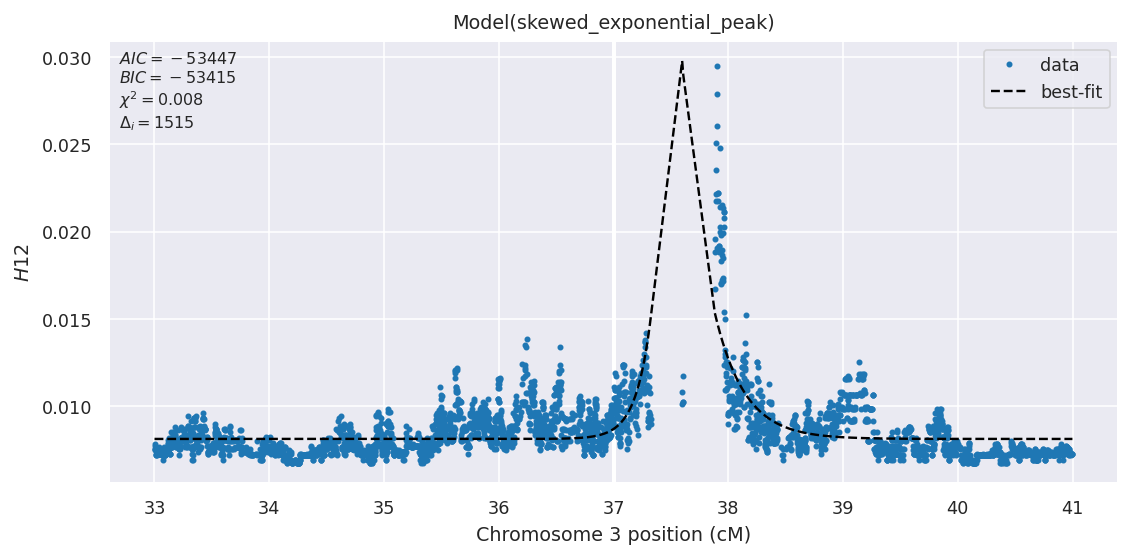

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 188
    # data points      = 4082
    # variables        = 5
    chi-square         = 0.00838420
    reduced chi-square = 2.0565e-06
    Akaike info crit   = -53446.8478
    Bayesian info crit = -53415.2761
[[Variables]]
    center:     37.5136750 +/- 0.01216025 (0.03%) (init = 37)
    amplitude:  0.03000000 +/- 4.1880e-04 (1.40%) (init = 0.5)
    decay:      0.18316027 +/- 0.00660976 (3.61%) (init = 0.5)
    skew:      -0.49999999 +/- 0.01712881 (3.43%) (init = 0)
    baseline:   0.00812829 +/- 2.4941e-05 (0.31%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)        =  0.954
    C(amplitude, decay)    =  0.933
    C(center, decay)       =  0.824
    C(decay, skew)         =  0.804
    C(center, amplitude)   =  0.760
    C(amplitude, skew)     =  0.709
    C(decay, b

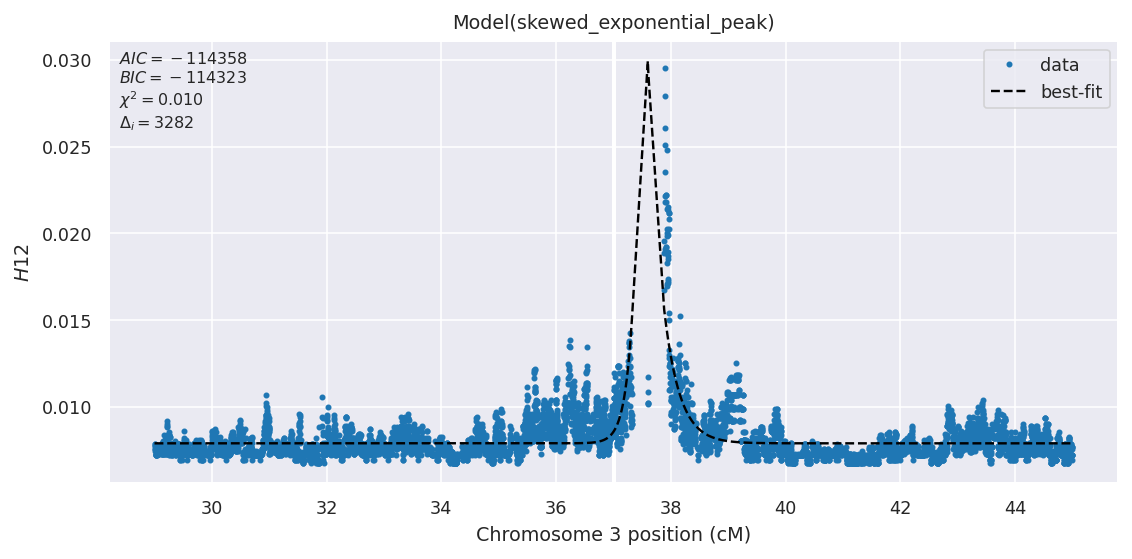

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 213
    # data points      = 8393
    # variables        = 5
    chi-square         = 0.01013836
    reduced chi-square = 1.2087e-06
    Akaike info crit   = -114357.909
    Bayesian info crit = -114322.733
[[Variables]]
    center:     37.5146994 +/- 0.00873556 (0.02%) (init = 37)
    amplitude:  0.03000000 +/- 0.00106510 (3.55%) (init = 0.5)
    decay:      0.19159079 +/- 0.00479194 (2.50%) (init = 0.5)
    skew:      -0.49999994 +/- 0.03548583 (7.10%) (init = 0)
    baseline:   0.00788401 +/- 1.2630e-05 (0.16%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)        =  0.951
    C(amplitude, decay)    = -0.930
    C(center, decay)       =  0.806
    C(decay, skew)         =  0.787
    C(center, amplitude)   = -0.726
    C(amplitude, skew)     = -0.674
    C(decay, b

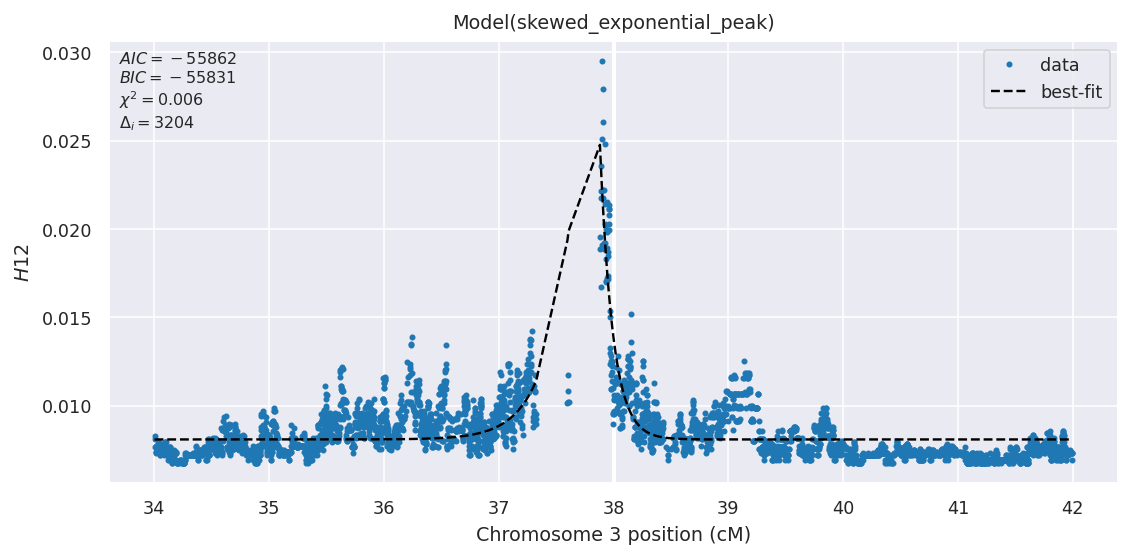

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 4150
    # variables        = 5
    chi-square         = 0.00590246
    reduced chi-square = 1.4240e-06
    Akaike info crit   = -55862.4851
    Bayesian info crit = -55830.8307
[[Variables]]
    center:     37.8157027 +/- 0.00578122 (0.02%) (init = 38)
    amplitude:  0.03000000 +/- 3.7733e-04 (1.26%) (init = 0.5)
    decay:      0.15728489 +/- 0.00354944 (2.26%) (init = 0.5)
    skew:       0.49999999 +/- 0.02066596 (4.13%) (init = 0)
    baseline:   0.00808290 +/- 2.0268e-05 (0.25%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)        =  0.868
    C(amplitude, decay)    =  0.801
    C(center, amplitude)   =  0.775
    C(amplitude, skew)     =  0.542
    C(center, decay)       =  0.379
    C(decay, baseline)     = -0.315
    C(decay, s

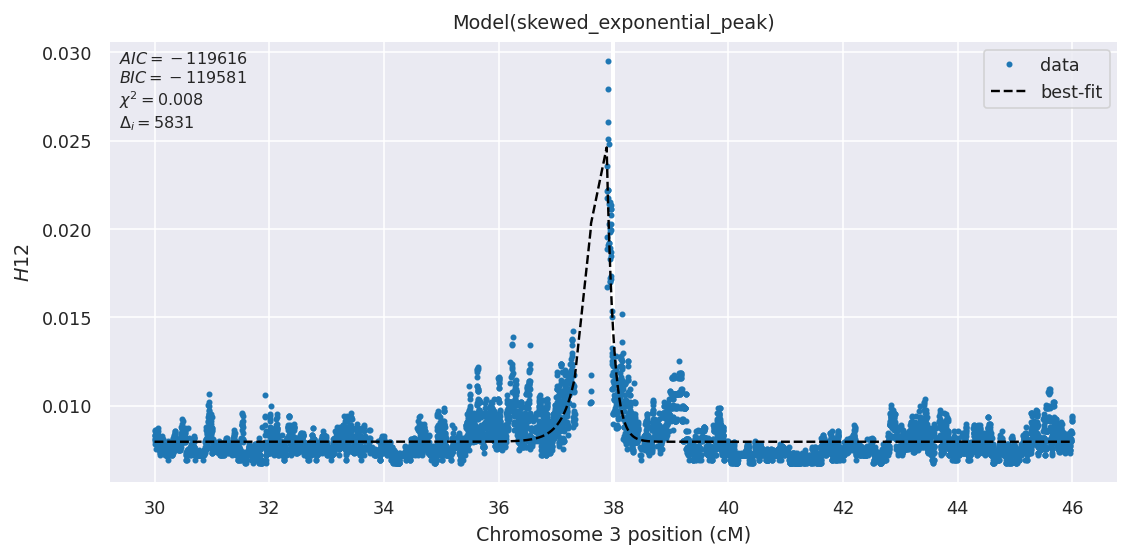

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 8590
    # variables        = 5
    chi-square         = 0.00769005
    reduced chi-square = 8.9575e-07
    Akaike info crit   = -119615.904
    Bayesian info crit = -119580.613
[[Variables]]
    center:     37.8130915 +/- 0.00447270 (0.01%) (init = 38)
    amplitude:  0.03000000 +/- 0.00107166 (3.57%) (init = 0.5)
    decay:      0.16332059 +/- 0.00271667 (1.66%) (init = 0.5)
    skew:       0.49999975 +/- 0.02345899 (4.69%) (init = 0)
    baseline:   0.00795263 +/- 1.0664e-05 (0.13%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)        =  0.870
    C(amplitude, decay)    = -0.801
    C(center, amplitude)   = -0.754
    C(amplitude, skew)     = -0.517
    C(center, decay)       =  0.344
    C(decay, baseline)     = -0.218
    C(decay, s

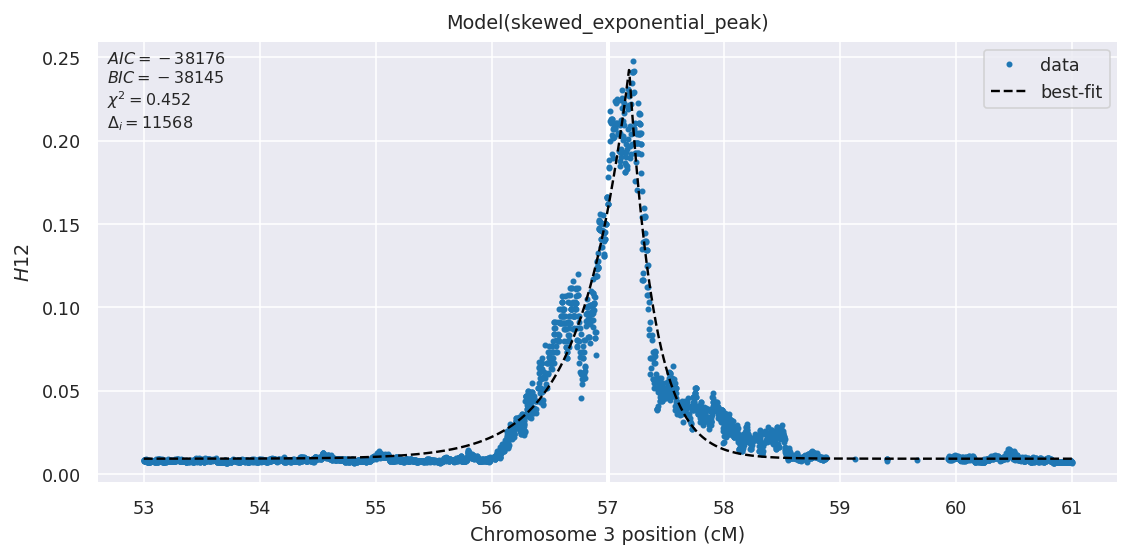

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 4181
    # variables        = 5
    chi-square         = 0.45158033
    reduced chi-square = 1.0814e-04
    Akaike info crit   = -38176.3597
    Bayesian info crit = -38144.6682
[[Variables]]
    center:     57.1834235 +/- 0.00158305 (0.00%) (init = 57)
    amplitude:  0.23382701 +/- 0.00123224 (0.53%) (init = 0.5)
    decay:      0.29965322 +/- 0.00249160 (0.83%) (init = 0.5)
    skew:       0.45351607 +/- 0.01075500 (2.37%) (init = 0)
    baseline:   0.00927408 +/- 1.9800e-04 (2.13%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.717
    C(amplitude, decay) = -0.627
    C(decay, baseline)  = -0.441
    C(decay, skew)      = -0.284
    C(center, decay)    = -0.202


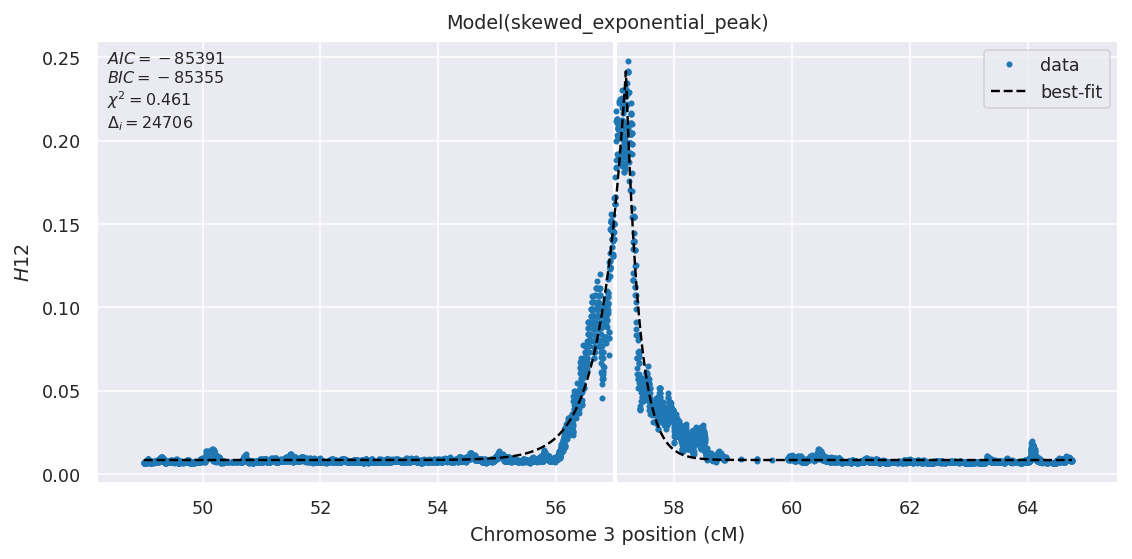

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 8676
    # variables        = 5
    chi-square         = 0.46069745
    reduced chi-square = 5.3131e-05
    Akaike info crit   = -85390.7277
    Bayesian info crit = -85355.3861
[[Variables]]
    center:     57.1827506 +/- 0.00112400 (0.00%) (init = 57)
    amplitude:  0.23348425 +/- 8.5581e-04 (0.37%) (init = 0.5)
    decay:      0.30496504 +/- 0.00165573 (0.54%) (init = 0.5)
    skew:       0.44732605 +/- 0.00748151 (1.67%) (init = 0)
    baseline:   0.00847642 +/- 8.5744e-05 (1.01%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.718
    C(amplitude, decay) = -0.659
    C(decay, skew)      = -0.309
    C(decay, baseline)  = -0.293
    C(center, decay)    = -0.222


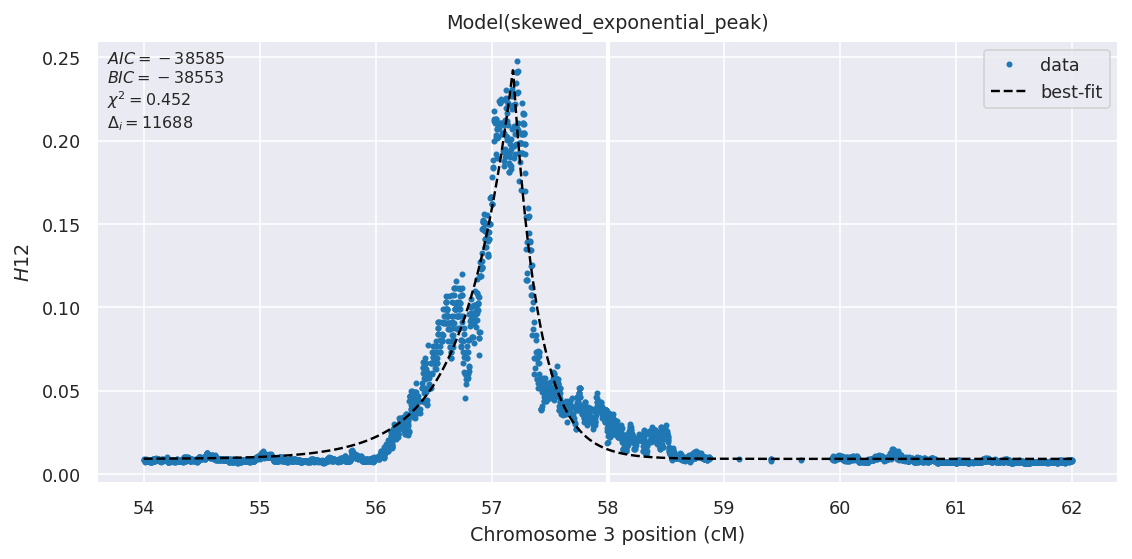

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data points      = 4222
    # variables        = 5
    chi-square         = 0.45232620
    reduced chi-square = 1.0726e-04
    Akaike info crit   = -38585.0579
    Bayesian info crit = -38553.3176
[[Variables]]
    center:     57.1833453 +/- 0.00157937 (0.00%) (init = 58)
    amplitude:  0.23377263 +/- 0.00122566 (0.52%) (init = 0.5)
    decay:      0.30038110 +/- 0.00248004 (0.83%) (init = 0.5)
    skew:       0.45279537 +/- 0.01070010 (2.36%) (init = 0)
    baseline:   0.00916602 +/- 1.9561e-04 (2.13%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.717
    C(amplitude, decay) = -0.627
    C(decay, baseline)  = -0.438
    C(decay, skew)      = -0.286
    C(center, decay)    = -0.203


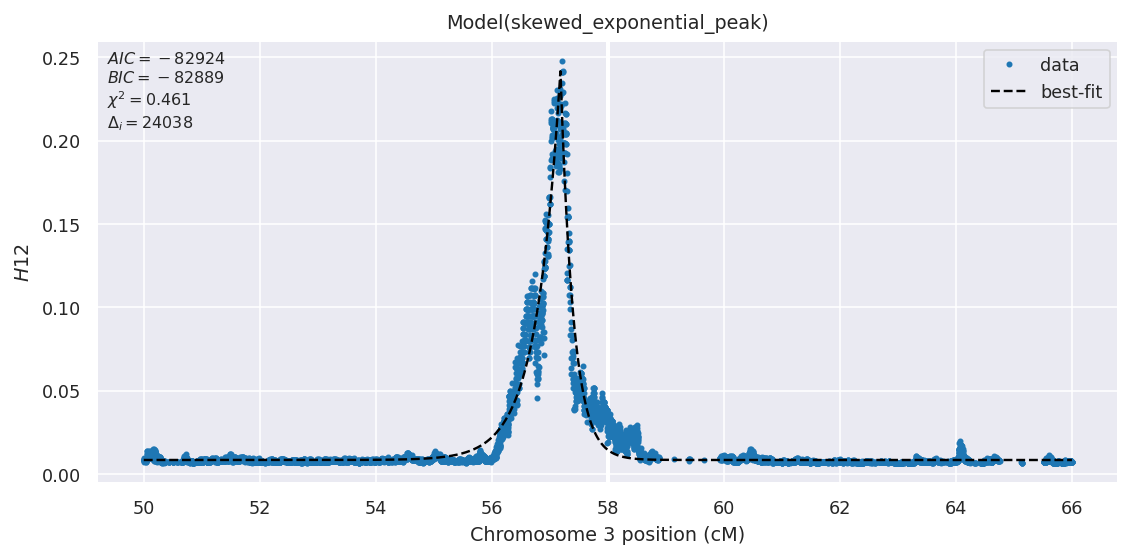

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 147
    # data points      = 8448
    # variables        = 5
    chi-square         = 0.46054672
    reduced chi-square = 5.4548e-05
    Akaike info crit   = -82924.2356
    Bayesian info crit = -82889.0271
[[Variables]]
    center:     57.1827716 +/- 0.00113842 (0.00%) (init = 58)
    amplitude:  0.23349544 +/- 8.6737e-04 (0.37%) (init = 0.5)
    decay:      0.30481100 +/- 0.00167946 (0.55%) (init = 0.5)
    skew:       0.44751699 +/- 0.00758444 (1.69%) (init = 0)
    baseline:   0.00849857 +/- 8.8279e-05 (1.04%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.718
    C(amplitude, decay) = -0.658
    C(decay, skew)      = -0.309
    C(decay, baseline)  = -0.297
    C(center, decay)    = -0.222


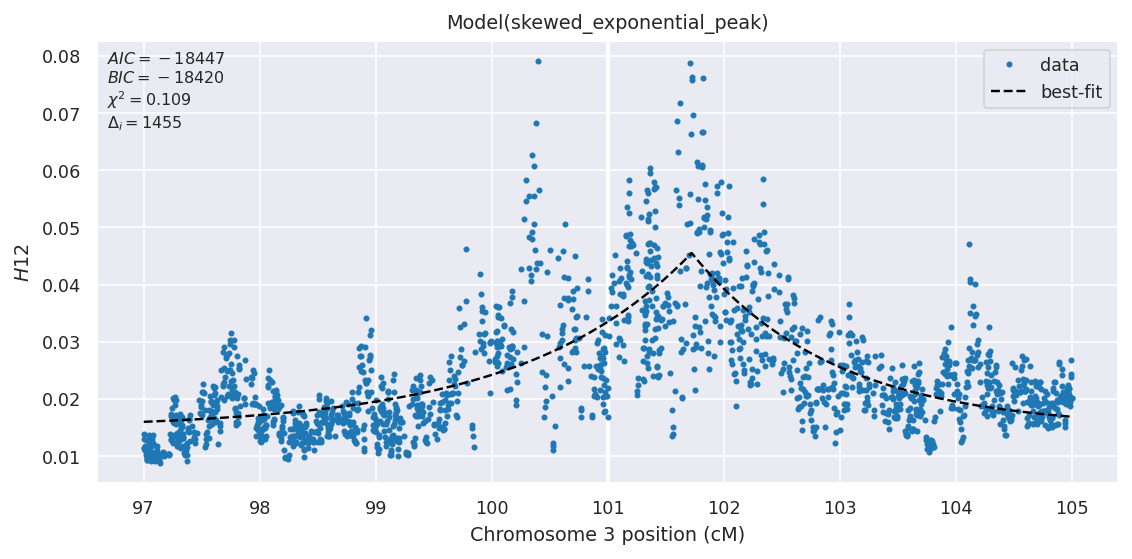

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 1891
    # variables        = 5
    chi-square         = 0.10906113
    reduced chi-square = 5.7827e-05
    Akaike info crit   = -18447.4985
    Bayesian info crit = -18419.7742
[[Variables]]
    center:     101.721942 +/- 0.02620348 (0.03%) (init = 101)
    amplitude:  0.03072873 +/- 6.5921e-04 (2.15%) (init = 0.5)
    decay:      1.33074593 +/- 0.09256850 (6.96%) (init = 0.5)
    skew:       0.12956788 +/- 0.04371551 (33.74%) (init = 0)
    baseline:   0.01478463 +/- 6.2572e-04 (4.23%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)     = -0.904
    C(center, skew)        =  0.700
    C(amplitude, baseline) = -0.404
    C(skew, baseline)      = -0.187
    C(decay, skew)         =  0.133
    C(center, baseline)    = -0.122


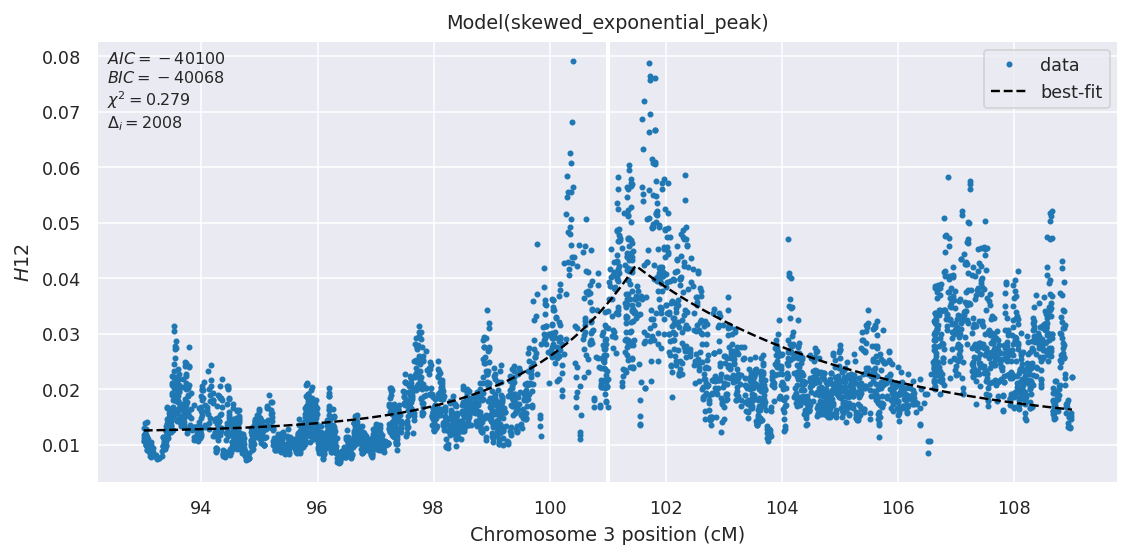

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3161
    # data points      = 4172
    # variables        = 5
    chi-square         = 0.27863170
    reduced chi-square = 6.6866e-05
    Akaike info crit   = -40099.6717
    Bayesian info crit = -40067.9910
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    skew:       at boundary
[[Variables]]
    center:     101.481038 (init = 101)
    amplitude:  0.03000000 (init = 0.5)
    decay:      2.66622344 (init = 0.5)
    skew:      -0.50000000 (init = 0)
    baseline:   0.01226062 (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)


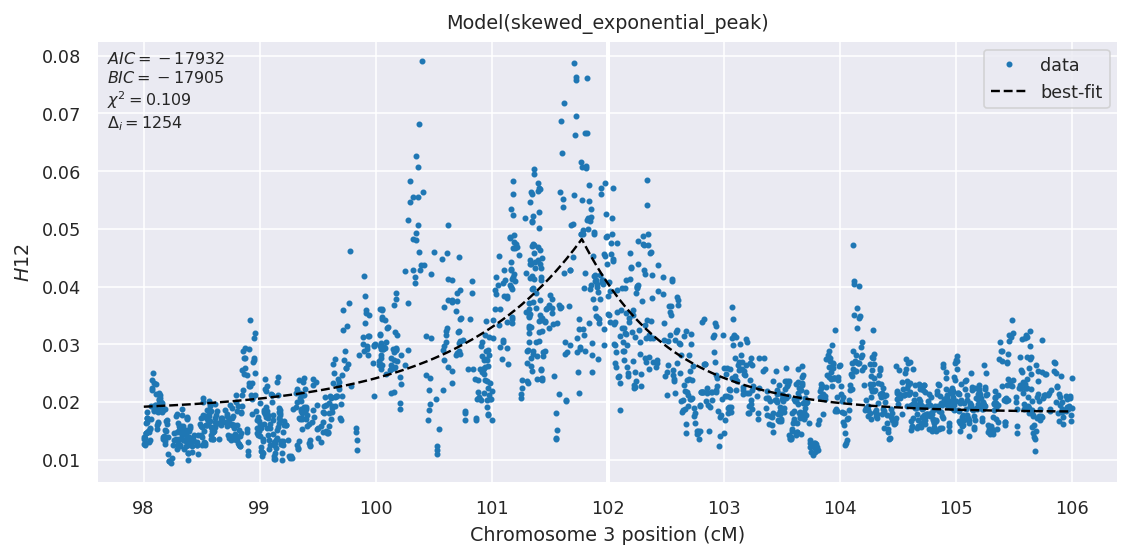

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 1843
    # variables        = 5
    chi-square         = 0.10901643
    reduced chi-square = 5.9313e-05
    Akaike info crit   = -17932.3544
    Bayesian info crit = -17904.7586
[[Variables]]
    center:     101.776016 +/- 0.02177786 (0.02%) (init = 102)
    amplitude:  0.03000000 +/- 0.00221177 (7.37%) (init = 0.5)
    decay:      0.90611945 +/- 0.05362561 (5.92%) (init = 0.5)
    skew:       0.26482226 +/- 0.05415237 (20.45%) (init = 0)
    baseline:   0.01822790 +/- 3.7177e-04 (2.04%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)  = -0.775
    C(center, skew)     =  0.697
    C(amplitude, decay) =  0.357
    C(decay, skew)      = -0.118


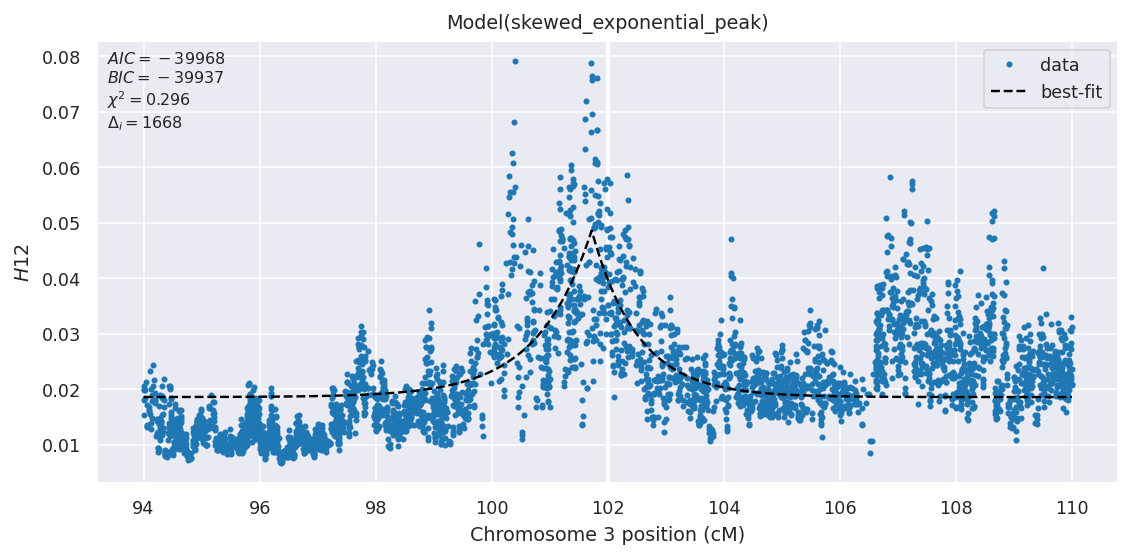

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 109
    # data points      = 4183
    # variables        = 5
    chi-square         = 0.29566028
    reduced chi-square = 7.0766e-05
    Akaike info crit   = -39968.3037
    Bayesian info crit = -39936.6098
[[Variables]]
    center:     101.721945 +/- 0.02378057 (0.02%) (init = 102)
    amplitude:  0.03000058 +/- 8.3583e-04 (2.79%) (init = 0.5)
    decay:      0.85963651 +/- 0.04185474 (4.87%) (init = 0.5)
    skew:       0.10900510 +/- 0.06066317 (55.65%) (init = 0)
    baseline:   0.01859984 +/- 1.6658e-04 (0.90%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.709
    C(amplitude, decay) = -0.627
    C(decay, baseline)  = -0.505


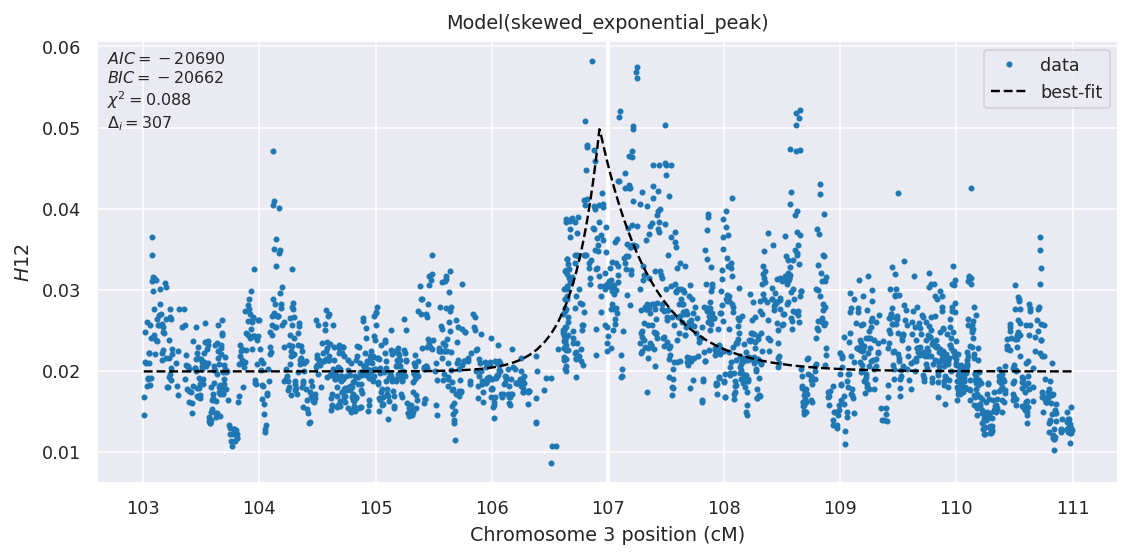

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 643
    # data points      = 2057
    # variables        = 5
    chi-square         = 0.08767260
    reduced chi-square = 4.2725e-05
    Akaike info crit   = -20689.8991
    Bayesian info crit = -20661.7541
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    baseline:   at boundary
[[Variables]]
    center:     106.927510 (init = 107)
    amplitude:  0.03000000 (init = 0.5)
    decay:      0.31679703 (init = 0.5)
    skew:      -0.49999325 (init = 0)
    baseline:   0.01991111 (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)


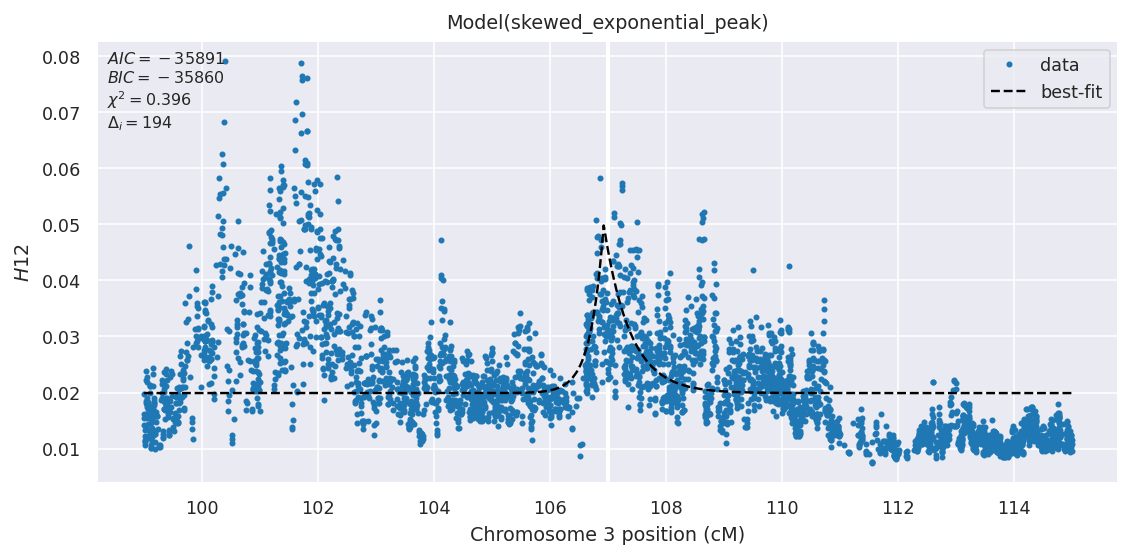

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 444
    # data points      = 3904
    # variables        = 5
    chi-square         = 0.39603779
    reduced chi-square = 1.0157e-04
    Akaike info crit   = -35891.1941
    Bayesian info crit = -35859.8453
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    baseline:   at boundary
[[Variables]]
    center:     106.927535 (init = 107)
    amplitude:  0.03000000 (init = 0.5)
    decay:      0.31700274 (init = 0.5)
    skew:      -0.49995515 (init = 0)
    baseline:   0.01991111 (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)


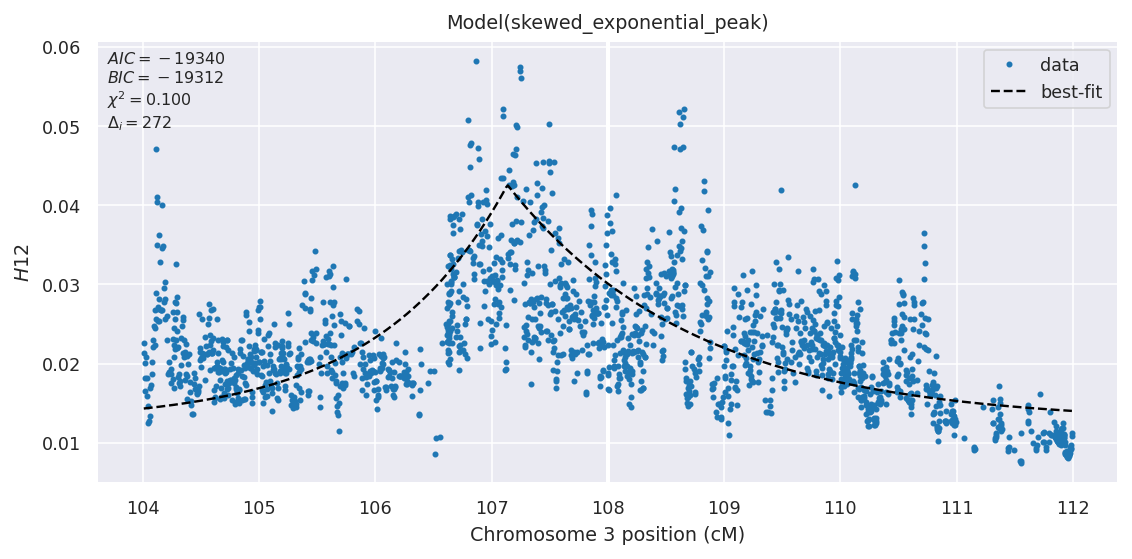

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1569
    # data points      = 1958
    # variables        = 5
    chi-square         = 0.09999727
    reduced chi-square = 5.1202e-05
    Akaike info crit   = -19339.5261
    Bayesian info crit = -19311.6278
[[Variables]]
    center:     107.136070 +/- 0.02387641 (0.02%) (init = 108)
    amplitude:  0.03000000 +/- 5.9150e-04 (1.97%) (init = 0.5)
    decay:      1.33330085 +/- 0.09186089 (6.89%) (init = 0.5)
    skew:      -0.27121140 +/- 0.04023374 (14.83%) (init = 0)
    baseline:   0.01256482 +/- 6.7424e-04 (5.37%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)     = -0.917
    C(center, skew)        =  0.700
    C(amplitude, baseline) =  0.550
    C(amplitude, decay)    = -0.275
    C(decay, skew)         =  0.153


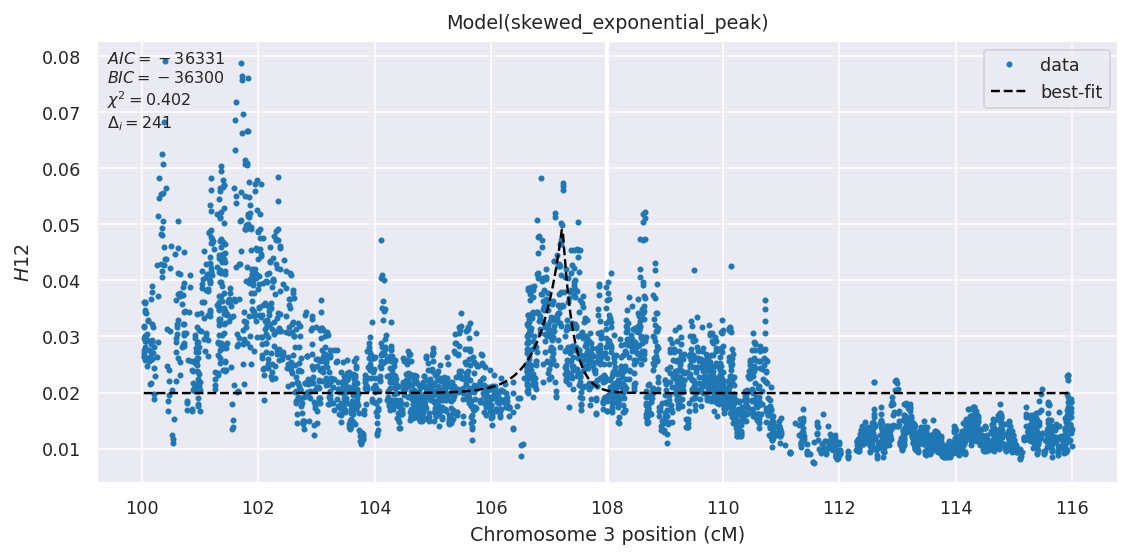

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 639
    # data points      = 3953
    # variables        = 5
    chi-square         = 0.40206685
    reduced chi-square = 1.0184e-04
    Akaike info crit   = -36331.3797
    Bayesian info crit = -36299.9685
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    baseline:   at boundary
[[Variables]]
    center:     107.233205 (init = 108)
    amplitude:  0.03000000 (init = 0.5)
    decay:      0.25845092 (init = 0.5)
    skew:       0.49993097 (init = 0)
    baseline:   0.01991111 (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)


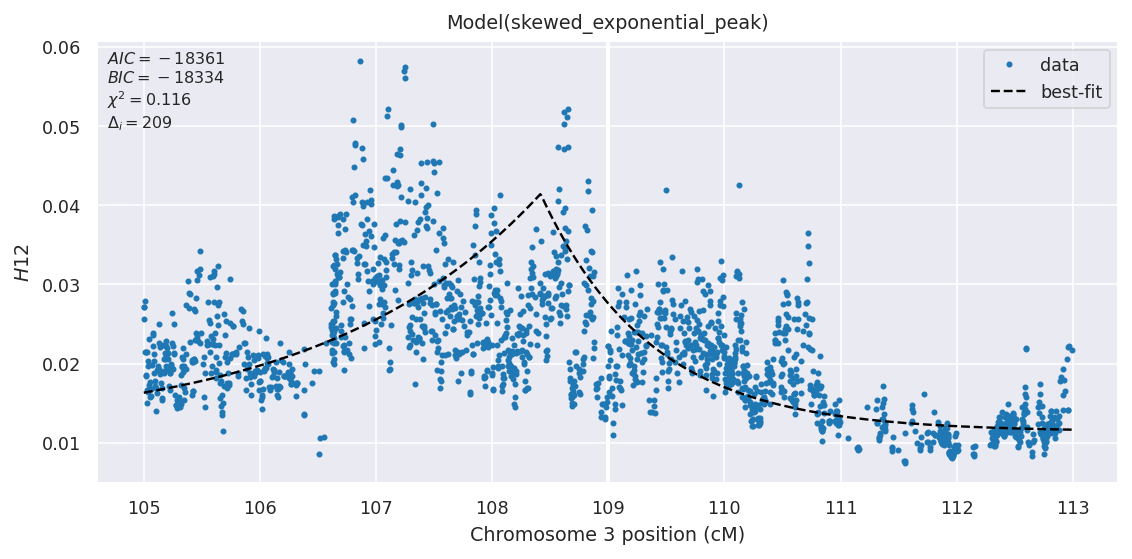

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1019
    # data points      = 1894
    # variables        = 5
    chi-square         = 0.11609927
    reduced chi-square = 6.1461e-05
    Akaike info crit   = -18361.3377
    Bayesian info crit = -18333.6055
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    decay:      at boundary
    skew:       at boundary
[[Variables]]
    center:     108.417223 (init = 109)
    amplitude:  0.03000000 (init = 0.5)
    decay:      1.33333001 (init = 0.5)
    skew:       0.50000000 (init = 0)
    baseline:   0.01142791 (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)


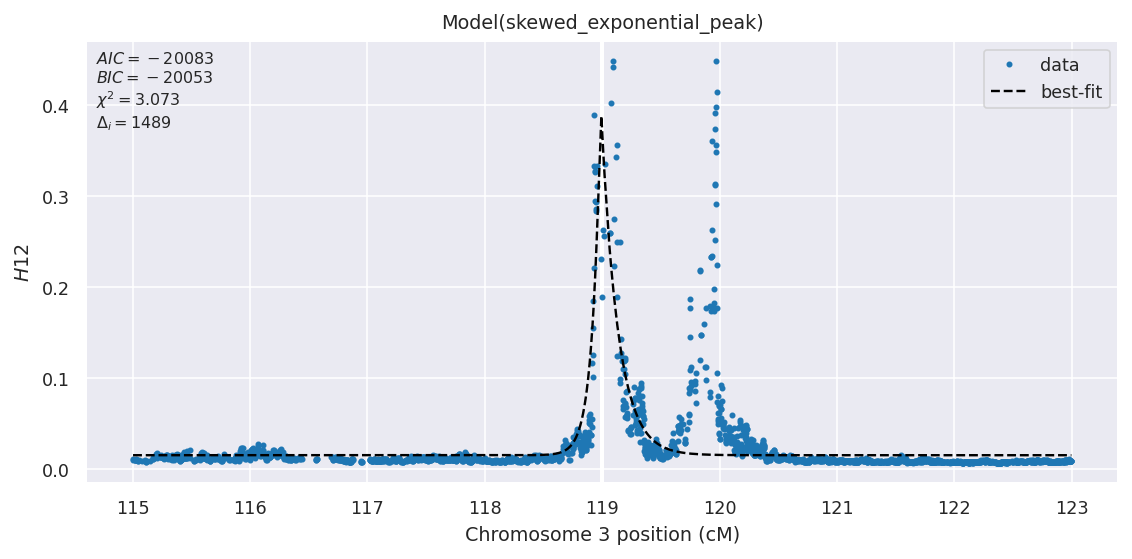

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 2929
    # variables        = 5
    chi-square         = 3.07251918
    reduced chi-square = 0.00105079
    Akaike info crit   = -20082.7014
    Bayesian info crit = -20052.7893
[[Variables]]
    center:     118.988306 +/- 0.00413878 (0.00%) (init = 119)
    amplitude:  0.38625383 +/- 0.01449699 (3.75%) (init = 0.5)
    decay:      0.10000000 +/- 0.00246889 (2.47%) (init = 0.5)
    skew:      -0.50000000 +/- 1.5677e-04 (0.03%) (init = 0)
    baseline:   0.01537649 +/- 6.3133e-04 (4.11%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = -0.850
    C(amplitude, decay)  = -0.782
    C(decay, skew)       = -0.526
    C(center, decay)     =  0.521
    C(amplitude, skew)   =  0.285
    C(center, amplitude) = -0.281
    C(decay, baseline)   =

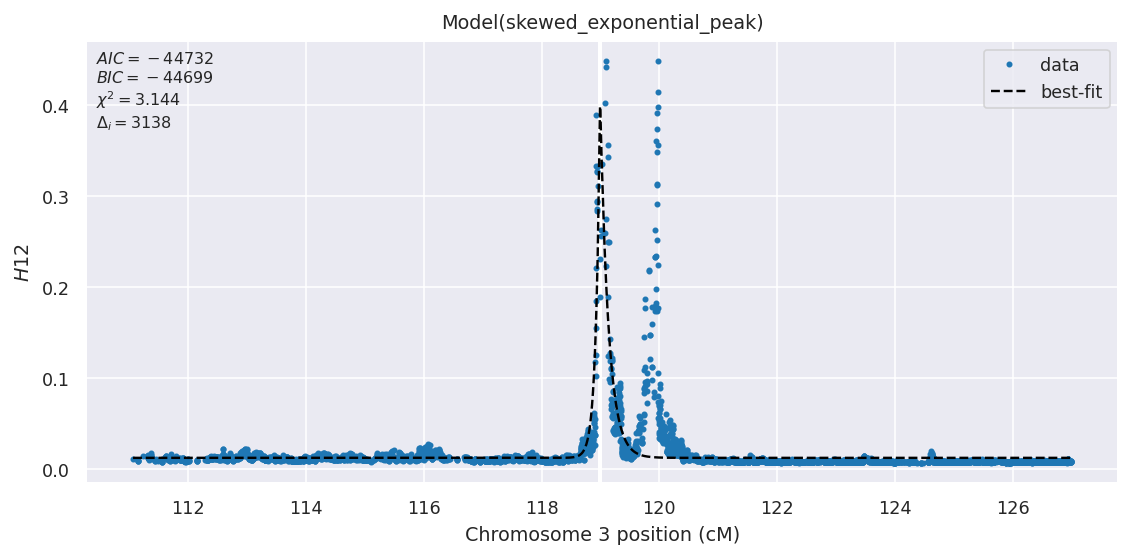

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 115
    # data points      = 5932
    # variables        = 5
    chi-square         = 3.14446930
    reduced chi-square = 5.3053e-04
    Akaike info crit   = -44731.9414
    Bayesian info crit = -44698.5008
[[Variables]]
    center:     118.994815 +/- 0.00249883 (0.00%) (init = 119)
    amplitude:  0.39404912 +/- 0.00959121 (2.43%) (init = 0.5)
    decay:      0.10079850 +/- 0.00248014 (2.46%) (init = 0.5)
    skew:      -0.49999997 +/- 0.06409454 (12.82%) (init = 0)
    baseline:   0.01230480 +/- 3.0663e-04 (2.49%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = -0.799
    C(amplitude, decay) = -0.737
    C(decay, skew)      = -0.372
    C(center, decay)    =  0.334
    C(decay, baseline)  = -0.149


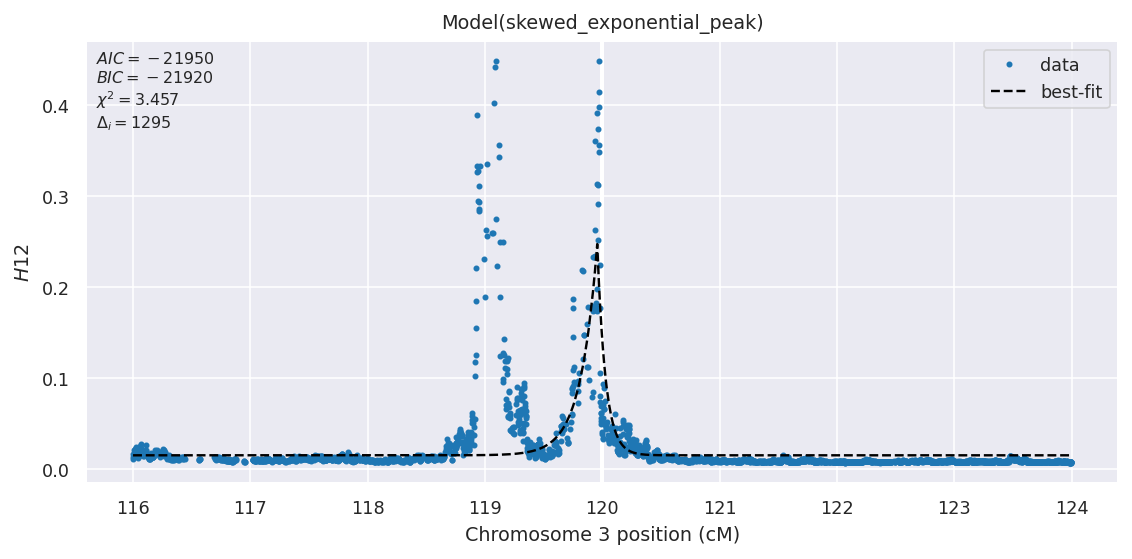

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 175
    # data points      = 3213
    # variables        = 5
    chi-square         = 3.45652668
    reduced chi-square = 0.00107747
    Akaike info crit   = -21949.8786
    Bayesian info crit = -21919.5038
[[Variables]]
    center:     119.957316 +/- 0.00303554 (0.00%) (init = 120)
    amplitude:  0.23204303 +/- 0.00796316 (3.43%) (init = 0.5)
    decay:      0.10003918 +/- 0.00498779 (4.99%) (init = 0.5)
    skew:       0.49995564 +/- 0.06974617 (13.95%) (init = 0)
    baseline:   0.01510059 +/- 6.0951e-04 (4.04%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.644
    C(amplitude, decay)  = -0.571
    C(center, amplitude) = -0.349
    C(decay, baseline)   = -0.245
    C(amplitude, skew)   = -0.155


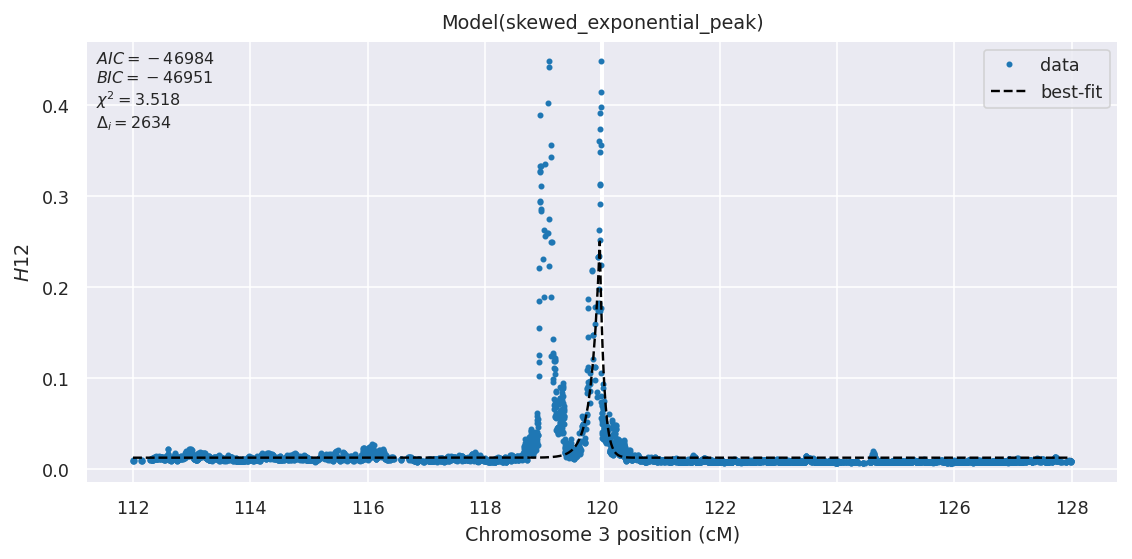

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 6277
    # variables        = 5
    chi-square         = 3.51796994
    reduced chi-square = 5.6090e-04
    Akaike info crit   = -46984.4135
    Bayesian info crit = -46950.6902
[[Variables]]
    center:     119.957316 +/- 0.00214134 (0.00%) (init = 120)
    amplitude:  0.23737811 +/- 0.00574448 (2.42%) (init = 0.5)
    decay:      0.10007770 +/- 0.00346350 (3.46%) (init = 0.5)
    skew:       0.49998261 +/- 0.04916264 (9.83%) (init = 0)
    baseline:   0.01247117 +/- 3.0667e-04 (2.46%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.644
    C(amplitude, decay)  = -0.580
    C(center, amplitude) = -0.349
    C(decay, baseline)   = -0.173
    C(amplitude, skew)   = -0.155


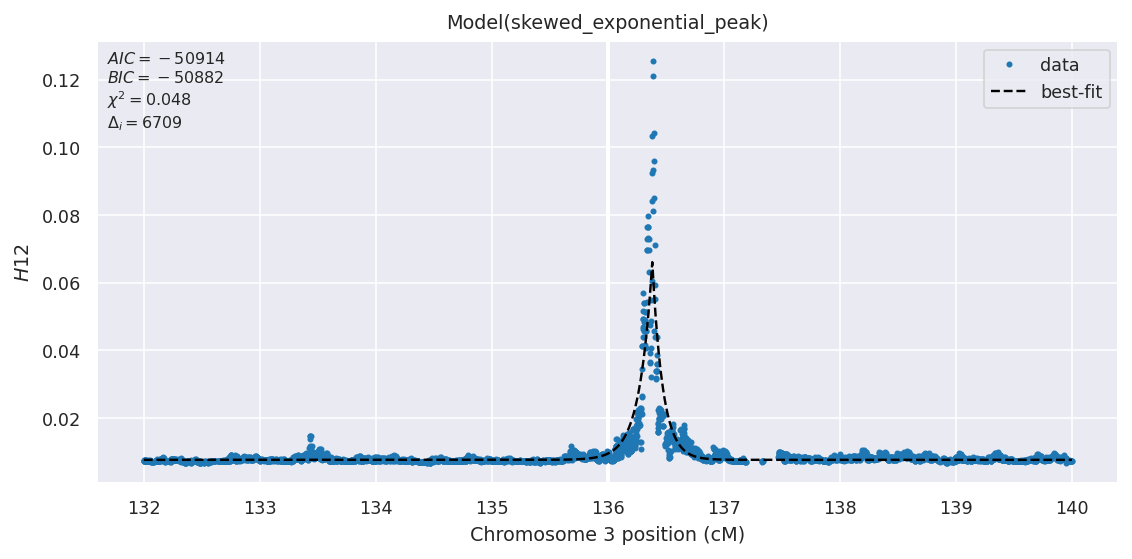

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 181
    # data points      = 4449
    # variables        = 5
    chi-square         = 0.04755623
    reduced chi-square = 1.0701e-05
    Akaike info crit   = -50914.4868
    Bayesian info crit = -50882.4846
[[Variables]]
    center:     136.383311 +/- 0.00112453 (0.00%) (init = 136)
    amplitude:  0.05840099 +/- 6.6261e-04 (1.13%) (init = 0.5)
    decay:      0.10001496 +/- 0.00159736 (1.60%) (init = 0.5)
    skew:       0.14552407 +/- 0.02241785 (15.40%) (init = 0)
    baseline:   0.00766179 +/- 5.1841e-05 (0.68%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.715
    C(amplitude, decay) = -0.691
    C(decay, baseline)  = -0.231
    C(decay, skew)      = -0.199


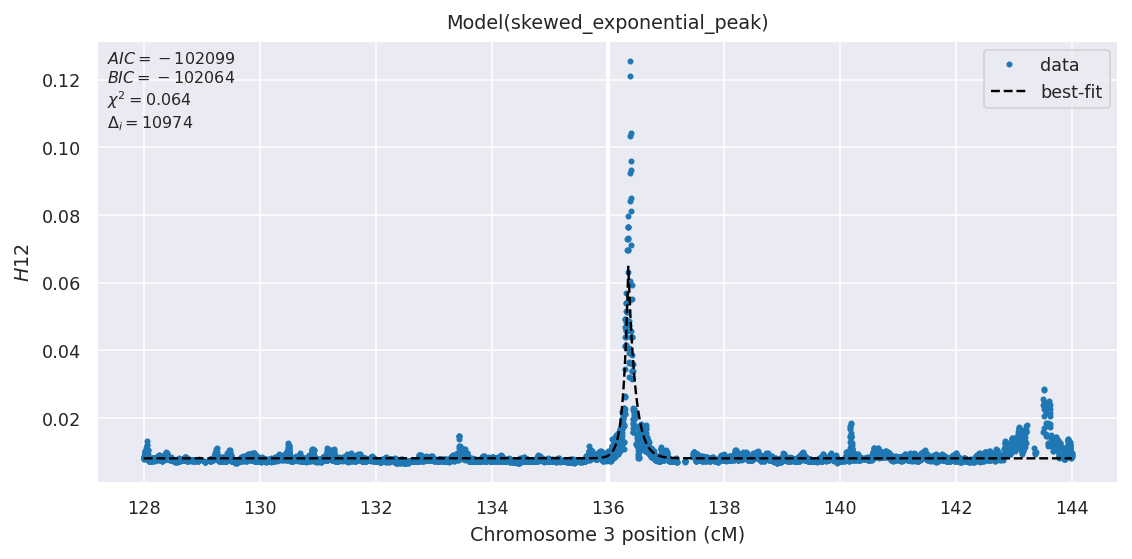

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 8647
    # variables        = 5
    chi-square         = 0.06433463
    reduced chi-square = 7.4444e-06
    Akaike info crit   = -102099.180
    Bayesian info crit = -102063.855
[[Variables]]
    center:     136.352335 +/- 9.4247e-04 (0.00%) (init = 136)
    amplitude:  0.05668612 +/- 5.5449e-04 (0.98%) (init = 0.5)
    decay:      0.10000000 +/- 4.5023e-05 (0.05%) (init = 0.5)
    skew:      -0.29201863 +/- 0.01879759 (6.44%) (init = 0)
    baseline:   0.00810609 +/- 3.0163e-05 (0.37%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.724
    C(amplitude, decay)  =  0.704
    C(center, amplitude) =  0.183
    C(decay, baseline)   =  0.167
    C(amplitude, skew)   =  0.145


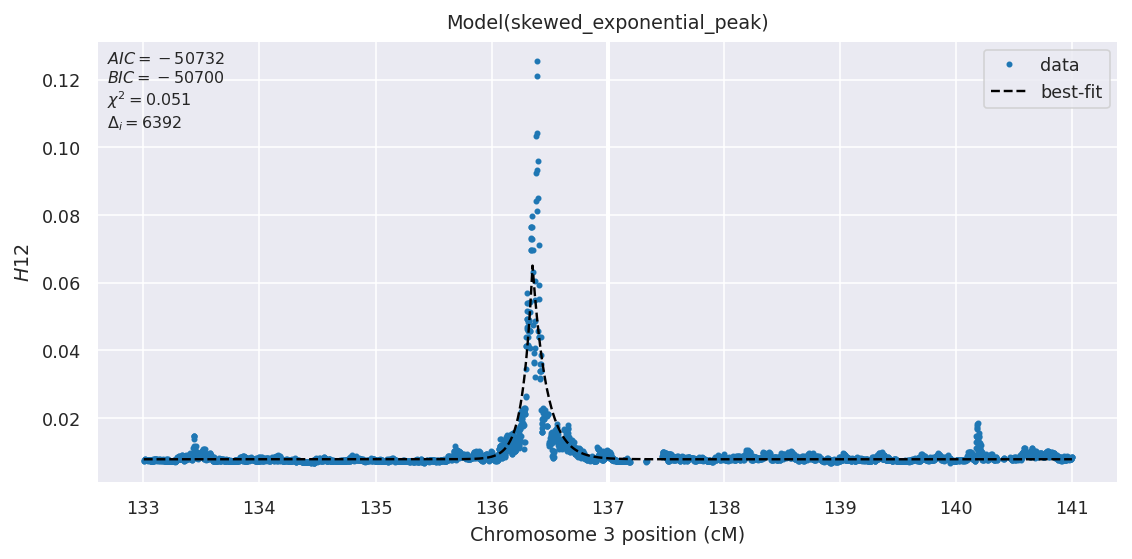

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 203
    # data points      = 4461
    # variables        = 5
    chi-square         = 0.05122550
    reduced chi-square = 1.1496e-05
    Akaike info crit   = -50732.2963
    Bayesian info crit = -50700.2806
[[Variables]]
    center:     136.352276 +/- 0.00115912 (0.00%) (init = 137)
    amplitude:  0.05725253 +/- 6.8938e-04 (1.20%) (init = 0.5)
    decay:      0.10000000 +/- 0.00471736 (4.72%) (init = 0.5)
    skew:      -0.29329671 +/- 0.02311799 (7.88%) (init = 0)
    baseline:   0.00783118 +/- 5.3634e-05 (0.68%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.724
    C(amplitude, decay)  =  0.695
    C(decay, baseline)   =  0.236
    C(center, amplitude) =  0.184
    C(amplitude, skew)   =  0.147


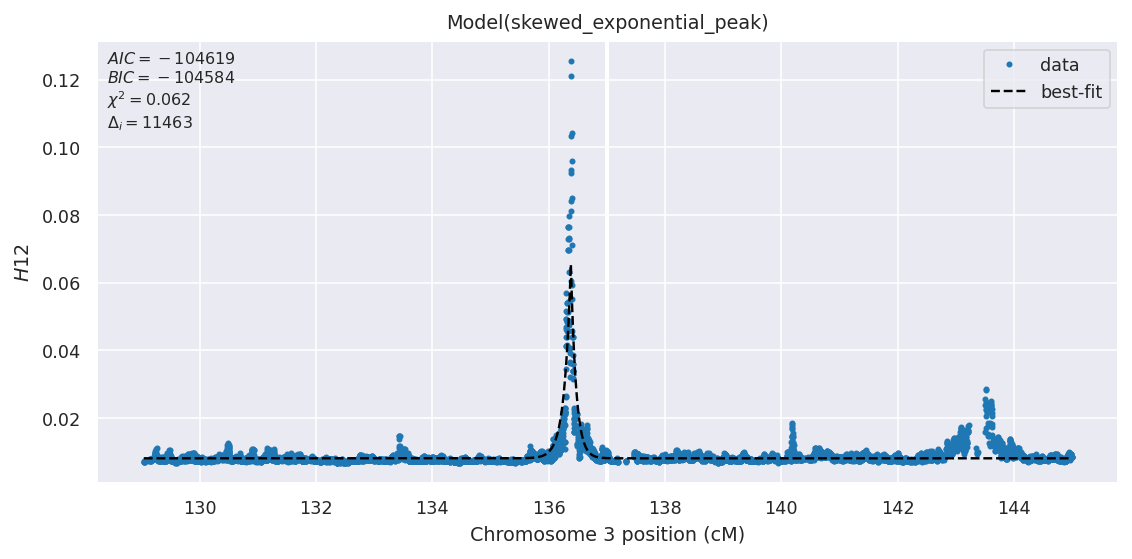

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 216
    # data points      = 8823
    # variables        = 5
    chi-square         = 0.06243855
    reduced chi-square = 7.0808e-06
    Akaike info crit   = -104619.219
    Bayesian info crit = -104583.793
[[Variables]]
    center:     136.383311 +/- 9.3537e-04 (0.00%) (init = 137)
    amplitude:  0.05732556 +/- 5.3662e-04 (0.94%) (init = 0.5)
    decay:      0.10000000 +/- 0.00133219 (1.33%) (init = 0.5)
    skew:       0.15855000 +/- 0.01869669 (11.79%) (init = 0)
    baseline:   0.00811261 +/- 2.9111e-05 (0.36%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.718
    C(amplitude, decay) = -0.702
    C(decay, skew)      = -0.251
    C(decay, baseline)  = -0.161
    C(center, decay)    = -0.110


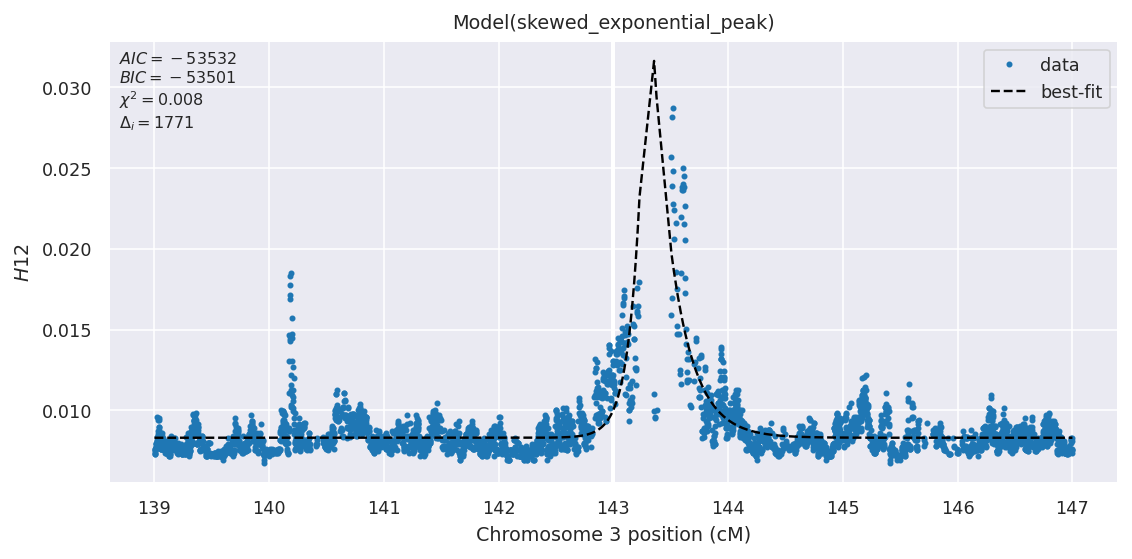

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 240
    # data points      = 4085
    # variables        = 5
    chi-square         = 0.00829572
    reduced chi-square = 2.0333e-06
    Akaike info crit   = -53532.4720
    Bayesian info crit = -53500.8966
[[Variables]]
    center:     143.301271 +/- 0.00488743 (0.00%) (init = 143)
    amplitude:  0.03000000 +/- 0.00147975 (4.93%) (init = 0.5)
    decay:      0.14936799 +/- 0.00380799 (2.55%) (init = 0.5)
    skew:      -0.49999595 +/- 0.03084098 (6.17%) (init = 0)
    baseline:   0.00831140 +/- 2.3910e-05 (0.29%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)        =  0.897
    C(amplitude, decay)    =  0.843
    C(center, decay)       =  0.579
    C(decay, skew)         =  0.572
    C(center, amplitude)   =  0.367
    C(amplitude, skew)     =  0.347
    C(decay, 

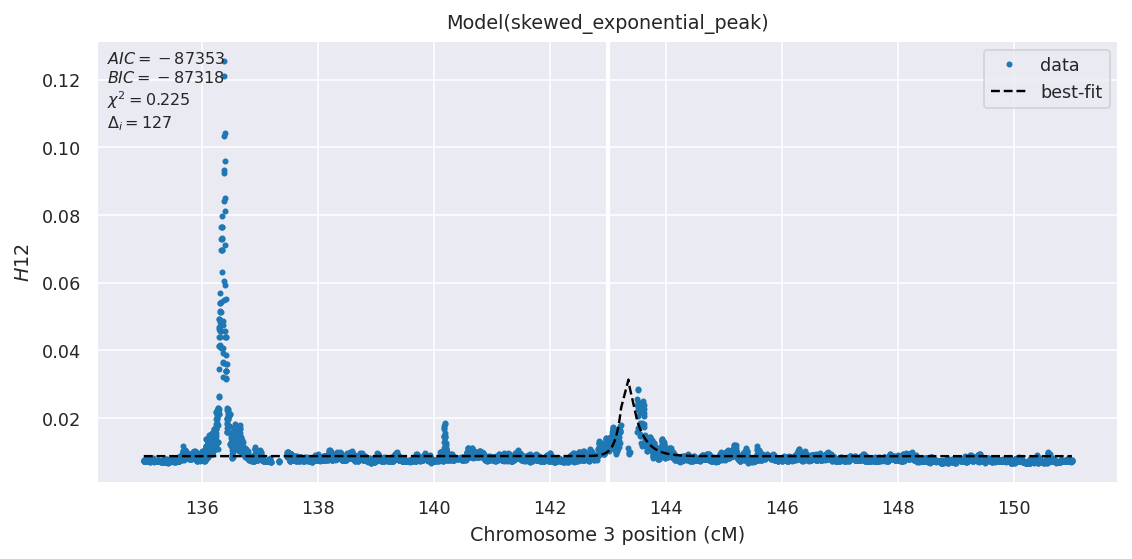

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 182
    # data points      = 8306
    # variables        = 5
    chi-square         = 0.22462529
    reduced chi-square = 2.7060e-05
    Akaike info crit   = -87352.9654
    Bayesian info crit = -87317.8417
[[Variables]]
    center:     143.299680 +/- 0.01838390 (0.01%) (init = 143)
    amplitude:  0.03000000 +/- 0.00702145 (23.40%) (init = 0.5)
    decay:      0.13733877 +/- 0.01373535 (10.00%) (init = 0.5)
    skew:      -0.49998897 +/- 0.10515308 (21.03%) (init = 0)
    baseline:   0.00874757 +/- 5.8778e-05 (0.67%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.899
    C(amplitude, decay)  =  0.851
    C(center, decay)     =  0.600
    C(decay, skew)       =  0.584
    C(center, amplitude) =  0.398
    C(amplitude, skew)   =  0.371
    C(decay, baseline)

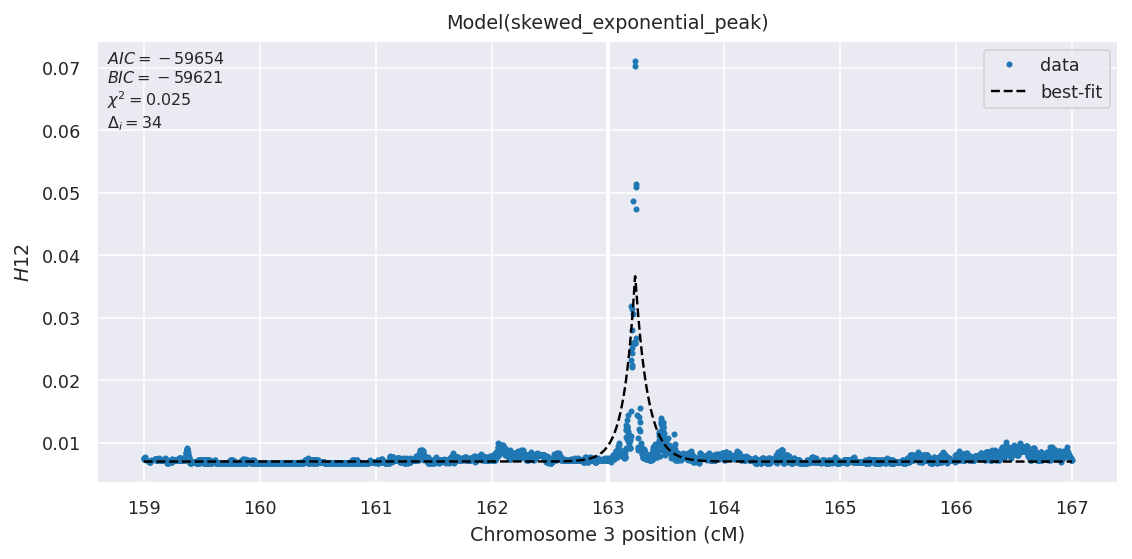

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 264
    # data points      = 4893
    # variables        = 5
    chi-square         = 0.02477077
    reduced chi-square = 5.0677e-06
    Akaike info crit   = -59653.5379
    Bayesian info crit = -59621.0601
[[Variables]]
    center:     163.235296 +/- 0.00155853 (0.00%) (init = 163)
    amplitude:  0.03000000 +/- 0.00132202 (4.41%) (init = 0.5)
    decay:      0.10000000 +/- 0.00209903 (2.10%) (init = 0.5)
    skew:      -0.07977682 +/- 0.02938884 (36.84%) (init = 0)
    baseline:   0.00697186 +/- 3.3757e-05 (0.48%) (init = 0.007911111)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.721
    C(amplitude, decay)  = -0.702
    C(decay, baseline)   =  0.218
    C(center, amplitude) = -0.105


In [12]:
peak_scan('bf_col', '3')